# Double Tap with Trend Analysis Feature Engineering

In this notebook we have reviewed our original double tap hypothesis based on some findings from double tap signals with various stochastic values. We note that the probability of a double tap win is impacted by the 30minute and 4hr trend and the stochastic value and in some case the stochastic can strongly infer a reversal whereby we could make a trade in the opposite direction to the original hypothesis. 

This new hypothesis states that: when a 30min candle closes in the opposite direction to the previous candle and both the 30minute and 4hr trend we are given a trade signal on the following stochastic condition. 

buy signal if signal candle buy and stoch(r) below 20.
sell signal if signal candle buy and stoch(r) above 40.
buy signal if signal candle sell and stoch (r) below 70.

OUr first job will be to engineer the required features including the following: \
(see features.txt for tech information)  
**thirty_trend** - the thirty minute trend \
**four_trend** - the four hour trend \
**dt_signal** - the basic double tap signal \
**sent_signal** - the sentiment confirmation \
**stoch_r** - %D slow moving average stochastic measure (red) \
**stoch_b** - %K fast moving average stochastic measure (blue) \
**rsi** - relative strength index \
**Plot** - 30minute sentiment strength imported from trading view
**candle_dir** - the closing direction of candle
**simple_result** - the win / loss outcome of trade based on next candle only \
**running_result** - the win / loss outcome of trade based on multiple subsequent candles (with sig_stop) \
**no_sig_result** - the win / loss outcome of trade based on multiple subsequent candles (without sig stops) \
**cur_sig_result** - the win / loss outcome of trade based on multiple subsequent candles (curated sig stops) \
**outcome** - the value of the trade following signal


In [2]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#set pandas to show all columns
pd.set_option("display.max_columns", None)

In [5]:
!ls

Double_Tap_Feature_Engineering.ipynb gj_4base.csv
Forex_Data_Analysis.ipynb            gj_4hour_trend.csv
Forex_Models.ipynb                   gj_4hr.csv
README.md                            gj_cleandraft.csv
forex.html                           gj_dt_4hrtrend.csv
gj30m_sentinc.csv                    gj_dt_trend.csv
gj4h_sentinc.csv                     gj_thirty_trend.csv
gj_30_RSI_exp.csv                    gpbjpy_dataframe_gen.ipynb
gj_30base.csv                        trend_feature_eng.ipynb
gj_30minsupres.csv


In [229]:
#Read in our 30minute data
thirty = pd.read_csv("gj_thirty_trend.csv")
thirty.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot  
0  86.245303  65.524837  0.070389  
1  82.185586  66.849987  0.061890  
2  79.502836  71.237596  0.058952  
3  79.377990  68.161801  0.053267  
4  81.179833  68.579229  0.047715

In [7]:
#Read in our 4hour data
four = pd.read_csv("gj_4hour_trend.csv")
four.head()

time     open     high      low    close      Plot
0  2019-01-06 22:00:00  138.091  138.334  137.922  138.090  0.005608
1  2019-01-07 02:00:00  138.090  138.105  137.724  137.932  0.037854
2  2019-01-07 06:00:00  137.932  138.102  137.616  137.956  0.065115
3  2019-01-07 10:00:00  137.956  138.382  137.796  138.322  0.097300
4  2019-01-07 14:00:00  138.322  138.774  138.168  138.738  0.134107

## FEATURE ENGINEERING 1.0

## Create the 30 minute trend feature

### Rules
* if previous candle,to signal candle, has a close higher than previous 4 candle average, then trend is long
* if previous candle, to signal candle, has a close lower than previous 4 candle average, then trend is short

In [230]:
#set a a global counter to iterate from within the function
x = 0

def trend_thirty(row):
    global x
    
    open_ = row[1]
    high = row[2]
    low = row[3]
    close = row[4]
    
    a = thirty['close']
    
    #we return unknown for the first 5 rows as we don't have access to enough prior data
    if x < 6:
        x+=1
        return "unknown"
    
    #set a variable to store the average values of previous 4 candles
    close_list = []
    
    #iterate through our four candles and add each closing price to the close list
    for i in a.loc[x-5:x-1]:
        close_list.append(i)
    
    #store the avearge close value in a variable
    ave_close = sum(close_list)/len(close_list)
    
    
    #execute our rules via a conditional statement and return the required trend directions 
    #ensure to iterate the x value for each return statement
    if a.loc[x-1] > ave_close:
        x+=1
        return "bullish"
    elif a.loc[x-1] < ave_close:
        x+=1
        return "bearish"
    else:
        x+=1
        return "flat"

In [231]:
#create a data frame column from the function
thirty_min = thirty.apply(trend_thirty, axis='columns').to_frame()
#join this new column to our existing thirty dataframe
thirty = thirty.join(thirty_min)
#rename the column to the required feature header
thirty.rename(columns={0: 'thirty_trend'}, inplace=True)
#View the head of our new dataframe
thirty.head(3)

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   

          %D        RSI      Plot thirty_trend  
0  86.245303  65.524837  0.070389      unknown  
1  82.185586  66.849987  0.061890      unknown  
2  79.502836  71.237596  0.058952      unknown

In [232]:
thirty.thirty_trend.value_counts()

bullish    10042
bearish     9997
flat          17
unknown        6
Name: thirty_trend, dtype: int64

In [233]:
#undrtake some manual checks to ensure the function has created the correct feature
thirty.iloc[712:720]

time     open     high      low    close         %K  \
712  2019-01-25 18:00:00  144.632  144.774  144.574  144.748  97.003553   
713  2019-01-25 18:30:00  144.748  144.797  144.664  144.783  96.764351   
714  2019-01-25 19:00:00  144.783  144.846  144.592  144.601  91.214069   
715  2019-01-25 19:30:00  144.601  144.708  144.596  144.696  87.368027   
716  2019-01-25 20:00:00  144.696  144.732  144.659  144.668  82.298424   
717  2019-01-25 20:30:00  144.668  144.742  144.638  144.704  85.480383   
718  2019-01-25 21:00:00  144.704  144.748  144.494  144.524  79.591428   
719  2019-01-25 21:30:00  144.524  144.600  144.486  144.582  76.462895   

            %D        RSI      Plot thirty_trend  
712  93.965013  74.506980  0.043301      bullish  
713  95.927452  75.125996  0.049478      bullish  
714  94.993991  66.133318  0.048079      bullish  
715  91.782149  68.268460  0.048301      bearish  
716  86.960173  66.929127  0.046433      bullish  
717  85.048945  67.803715  0.044687      bearish  
718  82.456745  59.351951  0.037203      bullish  
719  80.511569  61.037275  0.031813      bearish

Now we have created the thirty minute trend feature we need to do the same for the 4 hour timeframe. 

# Create the 4 hour trend feature

### Rules
* If the close of previous, to signal candle, is lower than the close of previous 1 candle and both candle closes are lower than their opens, then trend is bearish.
* If the close of previous, to signal candle, is lower than the close of previous 1 candle and both candle closes are high than their opens, then trend is bullish.

In [12]:
#Set a global counter to iterate from within the function
x = 0

def trend_four(row):
    global x #make our x variable accessible for updating within this function
    
    close = four['close']
    open_ = four['open']
    
    #We return unknown for the first few rows as we don't have the historical data
    if x < 4:
        x+=1
        return "unknown"
    
    if close.loc[x-1] < close.loc[x-2] and close.loc[x-1] < open_.loc[x-1] and close.loc[x-2] < open_.loc[x-2]:
        x+=1
        return "bearish"
    elif close.loc[x-1] > close.loc[x-2] and close.loc[x-1] > open_.loc[x-1] and close.loc[x-2] > open_.loc[x-2]:
        x+=1
        return "bullish"
    elif close.loc[x-3] < open_.loc[x-3] and close.loc[x-2] < open_.loc[x-2] and close.loc[x-1] < open_.loc[x-2]:
        x+=1
        return "bearish"
    elif close.loc[x-3] > open_.loc[x-3] and close.loc[x-2] > open_.loc[x-2] and close.loc[x-1] > open_.loc[x-2]:
        x+=1
        return "bullish"
    else:
        x+=1
        return "flat"
    
    

In [13]:
#create a data frame column from the function
four_hour = four.apply(trend_four, axis='columns').to_frame()
#join this new column to our existing thirty dataframe
four = four.join(four_hour)
#rename the column to the required feature header
four.rename(columns={0: 'four_trend'}, inplace=True)
#View the head of our new dataframe
four.head(3)

time     open     high      low    close      Plot  \
0  2019-01-06 22:00:00  138.091  138.334  137.922  138.090  0.005608   
1  2019-01-07 02:00:00  138.090  138.105  137.724  137.932  0.037854   
2  2019-01-07 06:00:00  137.932  138.102  137.616  137.956  0.065115   

  four_trend  
0    unknown  
1    unknown  
2    unknown

In [14]:
four.tail(6)

time     open     high      low    close      Plot  \
2502  2020-08-13 21:00:00  139.734  139.894  139.602  139.692  0.021159   
2503  2020-08-14 01:00:00  139.692  139.728  139.560  139.573  0.014485   
2504  2020-08-14 05:00:00  139.573  139.684  139.346  139.570  0.007972   
2505  2020-08-14 09:00:00  139.570  140.019  139.368  139.887  0.010346   
2506  2020-08-14 13:00:00  139.887  140.008  139.420  139.488  0.000200   
2507  2020-08-14 17:00:00  139.488  139.574  139.435  139.498 -0.008434   

     four_trend  
2502    bearish  
2503    bearish  
2504    bearish  
2505    bearish  
2506       flat  
2507       flat

In [15]:
four.four_trend.value_counts()

flat       955
bearish    789
bullish    760
unknown      4
Name: four_trend, dtype: int64

Ok so weve created the four hour sentiment based on our rules and now need to merge this information with the thirty minute dataframe. 

In [16]:
#first let's drop out all columns that are no longer required
four.drop(columns=['open', 'high', 'low', 'close'], inplace=True)

In [17]:
#We've decided to keep our sentiment plot from the import but this should be renamed to avoid confusion with 30min df
four.rename(columns={'Plot': '4h_plot'}, inplace=True)

In [18]:
four.head(2)

time   4h_plot four_trend
0  2019-01-06 22:00:00  0.005608    unknown
1  2019-01-07 02:00:00  0.037854    unknown

In [19]:
thirty.shape

(20062, 10)

In [20]:
four.shape

(2508, 3)

In [234]:
#Let's merge the dataframe
thirty = thirty.merge(four, how='left', left_on='time', right_on='time')


In [235]:
#quick review to see what we've produced. 
#As expected there are a lot of NAN values where 4hr and 30min times don't match up
thirty.loc[800:810]

time     open     high      low    close         %K  \
800  2019-01-29 14:00:00  144.420  144.468  144.136  144.276  91.040665   
801  2019-01-29 14:30:00  144.276  144.310  144.101  144.198  81.609689   
802  2019-01-29 15:00:00  144.198  144.228  144.078  144.200  72.357057   
803  2019-01-29 15:30:00  144.200  144.206  143.668  143.748  48.806872   
804  2019-01-29 16:00:00  143.748  143.804  143.464  143.742  34.287327   
805  2019-01-29 16:30:00  143.742  143.864  143.690  143.762  22.002033   
806  2019-01-29 17:00:00  143.762  143.928  143.585  143.647  24.707031   
807  2019-01-29 17:30:00  143.647  143.886  143.592  143.692  23.079427   
808  2019-01-29 18:00:00  143.692  143.774  143.665  143.743  22.460937   
809  2019-01-29 18:30:00  143.743  143.836  143.702  143.817  27.994792   
810  2019-01-29 19:00:00  143.817  144.049  143.762  143.920  35.416667   

            %D        RSI      Plot thirty_trend   4h_plot four_trend  
800  91.235416  60.493056  0.052170      bullish -0.024930    bullish  
801  88.287334  57.521927  0.050740      bullish       NaN        NaN  
802  81.669137  57.579459  0.048893      bearish       NaN        NaN  
803  67.591206  43.304528  0.034448      bearish       NaN        NaN  
804  51.817085  43.151595  0.022512      bearish       NaN        NaN  
805  35.032077  43.863264  0.013413      bearish       NaN        NaN  
806  26.998797  40.707620  0.003006      bearish       NaN        NaN  
807  23.262830  42.452295 -0.003919      bearish       NaN        NaN  
808  23.415799  44.447385 -0.007866      bearish -0.062017       flat  
809  24.511719  47.302169 -0.008812      bullish       NaN        NaN  
810  28.624132  51.071151 -0.006623      bullish       NaN        NaN

In [236]:
#Now we fill the NaN values by filling the values forward as the 4hr trend is constant for all the 30mins within 
#that four hour period
thirty['four_trend'] = thirty[["four_trend"]].fillna(method='ffill')

In [237]:
#We also need to fill the 4h_plot as they have the same Nan issue
thirty['4h_plot'] = thirty[['4h_plot']].fillna(method='ffill')

In [238]:
# thirty.loc[805:818]
#Looks good
thirty.loc[100:105]

time     open     high      low    close         %K  \
100  2019-01-09 00:00:00  138.542  138.639  138.464  138.540  92.431191   
101  2019-01-09 00:30:00  138.540  138.604  138.402  138.478  83.500852   
102  2019-01-09 01:00:00  138.478  138.606  138.448  138.595  83.205107   
103  2019-01-09 01:30:00  138.595  138.626  138.515  138.576  84.935357   
104  2019-01-09 02:00:00  138.576  138.747  138.570  138.692  91.084541   
105  2019-01-09 02:30:00  138.692  138.865  138.648  138.708  86.418232   

            %D        RSI      Plot thirty_trend   4h_plot four_trend  
100  89.940745  55.330865 -0.016851      bullish  0.198966    bearish  
101  88.759148  52.003431 -0.012456      bullish  0.198966    bearish  
102  86.379050  57.230465 -0.005631      bearish  0.198966    bearish  
103  83.880439  56.160841 -0.000707      bullish  0.198966    bearish  
104  86.408335  60.958403  0.006314      bullish  0.200412    bullish  
105  87.479377  61.582899  0.012141      bullish  0.200412    bullish

Ok so we have now included our multi time frame trend directions to the dataframe. Next up we'll include our basic double tap feature which basically identifies when a 30minute candle has closed in teh opposite direction to the previous thrity minute candle. 

## Create the thirty minute double tap feature

### Rules 
* if a 30min candle closes bullish and the previous candle closed bearish, then we have a bullish signal
* if a 30min candle closes bearish and the previous candle closed bullish, then we a have a bearish signal
* else we do not have a basic trade signal

In [239]:
#first we need to set a direction for our signal candle
def direction(row):
    open_ = row[1]
    close_ = row[4]
    
    if open_ < close_:
        return  'long'
    elif open_ > close_:
        return 'short'
    else:
        return 'neutral'

In [240]:
can_dir = thirty.apply(direction, axis='columns').to_frame()
thirty = thirty.join(can_dir)
thirty.rename(columns={0: 'candle_dir'}, inplace=True)

In [241]:
thirty.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend candle_dir  
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown      short  
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown       long  
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown       long  
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown      short  
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown       long

In [242]:
thirty.candle_dir.value_counts()

long       9984
short      9935
neutral     143
Name: candle_dir, dtype: int64

In [243]:
#Now we need to check if the candle has closed in the opposite direction to the previous candle hence 
#creating a partial signal
x = 0

def dt_signal(row):
    global x
    
    direction = thirty['candle_dir']
    
    if x == 0:
        x+=1
        return "unknown"
    
    #let's check if we get a double tap confirmation
    if direction.loc[x] == direction.loc[x-1] or direction.loc[x] == 'neutral':
        x += 1
        return "no_trade"
    elif direction.loc[x] == "neutral":
        x += 1
        return "no_trade"
    elif direction.loc[x] == "short":
        x+=1
        return "short"
    else:
        x+=1
        return "long"
    

In [244]:
double_tap = thirty.apply(dt_signal, axis='columns').to_frame()
thirty = thirty.join(double_tap)
thirty.rename(columns={0: 'dt_signal'}, inplace=True)

In [245]:
thirty.head(300)

time     open     high      low    close         %K  \
0    2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1    2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2    2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3    2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4    2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   
..                   ...      ...      ...      ...      ...        ...   
295  2019-01-15 01:30:00  139.875  140.053  139.806  139.830  88.205524   
296  2019-01-15 02:00:00  139.830  139.944  139.794  139.813  83.432074   
297  2019-01-15 02:30:00  139.813  139.894  139.794  139.865  78.102926   
298  2019-01-15 03:00:00  139.865  140.060  139.865  139.981  82.965157   
299  2019-01-15 03:30:00  139.981  140.038  139.943  140.036  90.236207   

            %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0    86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1    82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2    79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3    79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4    81.179833  68.579229  0.047715      unknown  0.005608    unknown   
..         ...        ...       ...          ...       ...        ...   
295  89.265853  68.267261  0.029658      bullish  0.156551    bullish   
296  89.114654  67.416881  0.034282      bullish  0.181083       flat   
297  83.246842  68.701184  0.038472      bullish  0.181083       flat   
298  81.500052  71.408571  0.043977      bullish  0.181083       flat   
299  83.768097  72.617991  0.048748      bullish  0.181083       flat   

    candle_dir dt_signal  
0        short   unknown  
1         long      long  
2         long  no_trade  
3        short     short  
4         long      long  
..         ...       ...  
295      short     short  
296      short  no_trade  
297       long      long  
298       long  no_trade  
299       long  no_trade  

[300 rows x 14 columns]

In [246]:
thirty.dt_signal.value_counts()

no_trade    9474
short       5296
long        5291
unknown        1
Name: dt_signal, dtype: int64

Ok, so we've added our basic signal feature that shows where we have a change of direction in the 30minute timeframe. Next we need to show if the direction of this signal candle is at odds to the multi time frame trends. 

## Create the Sentiment Signal Feature

### Rules

* If the dt_signal is closing in the opposite direction to both 30minute and 4hour trends then the sentiment signal equals trade, else no trade. 


In [247]:
def sentiment_signal(row):
    
    thirty = row[9]
    four = row[11]
    sig = row[13]
    
    if sig == "short" and thirty == "bullish" and four == "bullish":
        return "short_trade"
    elif sig == "long" and thirty == "bearish" and four == "bearish":
        return 'long_trade'
    else:
        return "no_trade"

In [248]:
sentiment = thirty.apply(sentiment_signal, axis='columns').to_frame()
thirty = thirty.join(sentiment)
thirty.rename(columns={0: 'sent_signal'}, inplace=True)

In [249]:
thirty.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal  
0      short   unknown    no_trade  
1       long      long    no_trade  
2       long  no_trade    no_trade  
3      short     short    no_trade  
4       long      long    no_trade

In [250]:
thirty.sent_signal.value_counts()

no_trade       17489
long_trade      1325
short_trade     1248
Name: sent_signal, dtype: int64

In eighteen months we have 1325 long and 1248 short sentiment signals which is 2573. That's approx 146 per month and around 30 per week. On that count there are plenty of trade opportunities. What we need to do know is figure out how many of these trade opportunities resulted in wins and how many in losses. 

## Create the Simple Win / Loss Feature

### Rules
* if a trade reaches a 9 pip advance on the next candle without the stop loss being broken (opposite end of signal candle) then the trade is a win. 
* If a trade reaches the stop loss then the trade is a loss
* If a the next candle closes in the opposite direction to our signal candle then sig_stop
* else trade remains oprn and running

In [260]:
#Set the global variable
x=0

def win_or_loss(row):
    global x
    
    high = thirty['high']
    low = thirty['low']
    signal = thirty['sent_signal']
    close = thirty['close']
    open_ = thirty['open']
    
    #create a variable to hold whether we want a long trade or a short trade
    long_short = ''
    
    #Now check what trade we've been signalled and save it to the variable, unless no signal in which case return NA
    if signal.loc[x] == "short_trade":
        long_short = "short"
    elif signal.loc[x] == "long_trade":
        long_short = "long"
    else: 
        x+=1
        return "no_trade"
    
    #First will state whether a short trade is succesful or not
#     for i, j in enumerate(high[x:x+1]):
    if long_short == "short":
        if high[x+1] > high[x]+0.02:
            x+=1
            return "loss"
        elif low[x+1] < close[x]-0.09:
            x+=1
            return "win"
        elif close[x+1] > open_[x+1]:
            x+=1
            return 'sig_stop'
        else:
            x+=1
            return "running_short"
                
    #Now we'll state whether a long trade is successful or not
#     for i, j in enumerate(low[x:x+1]):
    if long_short == "long":
        if low[x+1] < low[x]-0.02:
            x+=1
            return "loss"
        elif high[x+1] > close[x]+0.09:
            x+=1
            return "win"
        elif close[x+1] < open_[x+1]:
            x+=1
            return 'sig_stop'
        else:
            x+=1
            return "running_long"
            
    
    

In [261]:
result = thirty.apply(win_or_loss, axis='columns').to_frame()
thirty = thirty.join(result)
thirty.rename(columns={0: 'simple_result'}, inplace=True)

In [262]:
thirty.loc[800:820]

time     open     high      low    close         %K  \
800  2019-01-29 14:00:00  144.420  144.468  144.136  144.276  91.040665   
801  2019-01-29 14:30:00  144.276  144.310  144.101  144.198  81.609689   
802  2019-01-29 15:00:00  144.198  144.228  144.078  144.200  72.357057   
803  2019-01-29 15:30:00  144.200  144.206  143.668  143.748  48.806872   
804  2019-01-29 16:00:00  143.748  143.804  143.464  143.742  34.287327   
805  2019-01-29 16:30:00  143.742  143.864  143.690  143.762  22.002033   
806  2019-01-29 17:00:00  143.762  143.928  143.585  143.647  24.707031   
807  2019-01-29 17:30:00  143.647  143.886  143.592  143.692  23.079427   
808  2019-01-29 18:00:00  143.692  143.774  143.665  143.743  22.460937   
809  2019-01-29 18:30:00  143.743  143.836  143.702  143.817  27.994792   
810  2019-01-29 19:00:00  143.817  144.049  143.762  143.920  35.416667   
811  2019-01-29 19:30:00  143.920  143.976  143.093  143.138  27.409904   
812  2019-01-29 20:00:00  143.138  143.200  142.776  143.121  22.636309   
813  2019-01-29 20:30:00  143.121  143.374  142.740  142.991  12.634380   
814  2019-01-29 21:00:00  142.991  143.072  142.820  142.898  14.913675   
815  2019-01-29 21:30:00  142.898  143.000  142.836  142.944  12.766278   
816  2019-01-29 22:00:00  142.944  142.972  142.814  142.840  10.198218   
817  2019-01-29 22:30:00  142.840  143.042  142.840  143.032  14.279355   
818  2019-01-29 23:00:00  143.032  143.176  143.027  143.175  20.786620   
819  2019-01-29 23:30:00  143.175  143.178  142.943  143.130  28.444105   
820  2019-01-30 00:00:00  143.130  143.148  143.048  143.082  29.717341   

            %D        RSI      Plot thirty_trend   4h_plot four_trend  \
800  91.235416  60.493056  0.052170      bullish -0.024930    bullish   
801  88.287334  57.521927  0.050740      bullish -0.024930    bullish   
802  81.669137  57.579459  0.048893      bearish -0.024930    bullish   
803  67.591206  43.304528  0.034448      bearish -0.024930    bullish   
804  51.817085  43.151595  0.022512      bearish -0.024930    bullish   
805  35.032077  43.863264  0.013413      bearish -0.024930    bullish   
806  26.998797  40.707620  0.003006      bearish -0.024930    bullish   
807  23.262830  42.452295 -0.003919      bearish -0.024930    bullish   
808  23.415799  44.447385 -0.007866      bearish -0.062017       flat   
809  24.511719  47.302169 -0.008812      bullish -0.062017       flat   
810  28.624132  51.071151 -0.006623      bullish -0.062017       flat   
811  30.273788  32.226211 -0.025988      bullish -0.062017       flat   
812  28.487626  31.950204 -0.041061      bearish -0.062017       flat   
813  20.893531  29.845150 -0.055602      bearish -0.062017       flat   
814  16.728121  28.403418 -0.068475      bearish -0.062017       flat   
815  13.438111  30.199511 -0.076059      bearish -0.062017       flat   
816  12.626057  28.461116 -0.083447      bearish -0.088021    bearish   
817  12.414617  35.807680 -0.082525      bearish -0.088021    bearish   
818  15.088064  40.692736 -0.076462      bullish -0.088021    bearish   
819  21.170027  39.669664 -0.071566      bullish -0.088021    bearish   
820  26.316022  38.556149 -0.067713      bullish -0.088021    bearish   

    candle_dir dt_signal  sent_signal simple_result  
800      short     short  short_trade           win  
801      short  no_trade     no_trade      no_trade  
802       long      long     no_trade      no_trade  
803      short     short     no_trade      no_trade  
804      short  no_trade     no_trade      no_trade  
805       long      long     no_trade      no_trade  
806      short     short     no_trade      no_trade  
807       long      long     no_trade      no_trade  
808       long  no_trade     no_trade      no_trade  
809       long  no_trade     no_trade      no_trade  
810       long  no_trade     no_trade      no_trade  
811      short     short     no_trade      no_trade  
812      short  no_trade     no_trade      no_trade  
813   

In [263]:
thirty.simple_result.value_counts()

no_trade         17489
win                793
sig_stop           693
loss               530
running_long       290
running_short      267
Name: simple_result, dtype: int64

In [264]:
#let's quickly check what our win/loss class is made up of
thirty.loc[thirty["simple_result"]=='loss'].sent_signal.value_counts()

long_trade     272
short_trade    258
Name: sent_signal, dtype: int64

In [265]:
# thirty.drop(columns=['simple_result'], inplace=True)

So we've create a simple result feature which states whether we achieve a 9 pip gain or a stop out in the very next candle. This is great as this win signifies our TP1 where we'd have a partial close to secure profits. At this stage we'd move our stops to break even to ensure we eliminate further risk.  

What we want to create next is a strategy for the incomplete trades labelled running - short/long. For this we'll need to review the next few candles to see if there is a new signal, a stop out or a win! 

## Create the Running Win / Loss Feature

### Rules
* if the simple win / loss is win and if we can secure another 10 pips over next 4 candles before our break even tapped: then win,  else we remain at win
* if the simple win / loss is running_long or running_short and we can secure 10 pips over the next 4 candles before our break even is tapped and there is no change in signal direction: then win, else if we're stopped then loss, else if we're stopped by a signal change then "sig_stop", else remain as a runner.

*We imagine that this approach will reduce the runners although we may end up with considerable signal stops. We have yet to fully realise how to approach new signals if the trade has not reached TP1. For now let's see what our final numbers look like before choosing an approach* 


In [266]:
x=0

def running_result(row):
    global x
    
    #We'll add a print report to show the progress we're making mid function execute
    if x%50 == 0: 
        print("processing row {}".format(x))
    
    #First we store our features in variables for use when iterating
    simple = thirty['simple_result']
    open_ = thirty['open']
    high = thirty['high']
    low = thirty['low']
    close = thirty['close']
    signal = thirty['sent_signal']
    
    #Create a variable to store whether the current trade is long, short or no trade
    long_short = ''
    
    if signal.loc[x] == "short_trade":
        long_short = "short"
    elif signal.loc[x] == "long_trade":
        long_short = "long"
    else: 
        x+=1
        return "no_trade"
    
    #set counters 
    short_count = 0
    long_count = 0
    
    #set an empty list to store our individual candle outcomes
    can_list = []
    
    #First we check the first part of our rules... what do our wins convert to?
    for i, (j, k, l, m) in enumerate(zip(open_[x+2:], high[x+2:], low[x+2:], close[x+2:])):
        
        
        if len(can_list) < 4 and long_short == 'short' and simple[x] == 'win':
            if high[x] < k:
                can_list.append('loss')
                    
            elif close[x] - l > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner')
                    
                    
        elif len(can_list) < 4 and long_short == 'long' and simple[x] == 'win':
            if low[x] > l:
                can_list.append('loss')
                    
            elif k - close[x] > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner')
        
        elif simple[x] == 'loss':
            x+=1
            return 'no_runner'
        
        elif simple[x] == 'sig_stop':
            x+=1
            return 'no_runner'
        
        
                    
                    
    #Next we create a new loop to check the runners to see what they convert to
    for i, (j, k, l, m, n) in enumerate(zip(open_[x+2:], high[x+2:], low[x+2:], close[x+2:], simple[x+2:])):
        
        if len(can_list) < 4 and long_short == 'short' and simple[x] == 'running_short':
            if high[x] < k:
                can_list.append('loss')
                    
            elif close[x] - l > 0.10:
                can_list.append('win')
                
            #if the candle closes in opposite direction to trade, then we get a new signal and close trade
            elif m > j: #close greater than open meaning a bull candle formed
                can_list.append('sig_stop')
                    
            else:
                can_list.append('runner')
                    
        elif len(can_list) < 4 and long_short == 'long' and simple[x] == 'running_long':
            if low[x] > l:
                can_list.append('loss')
                    
            elif k - close[x] > 0.10:
                can_list.append('win')
                    
            elif m < j:
                can_list.append('sig_stop')
                    
            else:
                can_list.append('runner') 
                
    
    #Now we check what order the results are sent to our can list. If we get a loss first then the trade will lose
    # if get a win first then the trade has made a win, if we get a sig_stop first then we've been stopped by a new
    #signal. Else if none of these things happen our trade remains as a runner
    
    if len(can_list)==4: #If our container has stored the next 3 candle outcomes, proceed. 
        if can_list[0] == 'loss':
            x+=1 #increment x by one
            return 'loss' #and return the trade outcome
        elif can_list[0] == 'win':
            x+=1
            return 'win'
        elif can_list[0] == 'sig_stop':
            x+=1
            return 'sig_stop'
        elif can_list[0] == 'runner' and can_list[1] == 'loss':
            x+=1
            return 'loss'
        elif can_list[0] == 'runner' and can_list[1] == 'win':
            x+=1
            return 'win'
        elif can_list[0] == 'runner' and can_list[1] == 'sig_stop':
            x+=1
            return 'sig_stop'
        elif can_list[1] == 'runner' and can_list[2] == 'loss':
            x+=1
            return 'loss'
        elif can_list[1] == 'runner' and can_list[2] == 'win':
            x+=1
            return 'win'
        elif can_list[1] == 'runner' and can_list[2] == 'sig_stop':
            x+=1
            return 'sig_stop'
        elif can_list[2] == 'runner' and can_list[3] =='loss':
            x+=1
            return 'loss'
        elif can_list[2] == 'runner' and can_list[3] =='win':
            x+=1
            return 'win'
        elif can_list[2] == 'runner' and can_list[3] =='sig_stop':
            x+=1
            return 'sig_stop'
        else:
            x+=1
            return 'runner'
                
    
    
    
    
    
    

In [267]:
running = thirty.apply(running_result, axis='columns').to_frame()
thirty = thirty.join(running)
thirty.rename(columns={0: 'running_result'}, inplace=True)

processing row 0
processing row 50
processing row 100
processing row 150
processing row 200
processing row 250
processing row 300
processing row 350
processing row 400
processing row 450
processing row 500
processing row 550
processing row 600
processing row 650
processing row 700
processing row 750
processing row 800
processing row 850
processing row 900
processing row 950
processing row 1000
processing row 1050
processing row 1100
processing row 1150
processing row 1200
processing row 1250
processing row 1300
processing row 1350
processing row 1400
processing row 1450
processing row 1500
processing row 1550
processing row 1600
processing row 1650
processing row 1700
processing row 1750
processing row 1800
processing row 1850
processing row 1900
processing row 1950
processing row 2000
processing row 2050
processing row 2100
processing row 2150
processing row 2200
processing row 2250
processing row 2300
processing row 2350
processing row 2400
processing row 2450
processing row 2500
pro

In [281]:
thirty.tail()

time     open     high      low    close         %K  \
20057  2020-08-14 18:30:00  139.516  139.554  139.472  139.496  17.139677   
20058  2020-08-14 19:00:00  139.496  139.551  139.484  139.511  14.635504   
20059  2020-08-14 19:30:00  139.511  139.520  139.466  139.480  12.694627   
20060  2020-08-14 20:00:00  139.480  139.550  139.480  139.537  16.142521   
20061  2020-08-14 20:30:00  139.537  139.555  139.435  139.498  17.644182   

              %D        RSI      Plot thirty_trend   4h_plot four_trend  \
20057  17.139677  42.368890 -0.017203      bullish -0.008434       flat   
20058  16.564645  43.486229 -0.017296      bearish -0.008434       flat   
20059  14.823269  41.687407 -0.017934      bearish -0.008434       flat   
20060  14.490884  46.102152 -0.016597      bearish -0.008434       flat   
20061  15.493777  43.666230 -0.016342      bullish -0.008434       flat   

      candle_dir dt_signal sent_signal simple_result running_result  
20057      short  no_trade    no_trade      no_trade       no_trade  
20058       long      long    no_trade      no_trade       no_trade  
20059      short     short    no_trade      no_trade       no_trade  
20060       long      long    no_trade      no_trade       no_trade  
20061      short     short    no_trade      no_trade       no_trade

In [282]:
thirty.simple_result.value_counts()

no_trade         17489
win                793
sig_stop           693
loss               530
running_long       290
running_short      267
Name: simple_result, dtype: int64

In [283]:
thirty.running_result.value_counts()

no_trade     17489
no_runner     1223
win            835
sig_stop       250
loss           239
runner          26
Name: running_result, dtype: int64

So now we have our results added we'd like to know what the overall profit and loss is on each trade. We'll add this feature in the next function.

## Create the Profit and Loss Feature

### Rules
* values are measured in pips
* If simple result and running result are wins; then profit is 17. DONE
* If simple result is a loss; loss is equal to signal candle close-high for shorts and low-close for longs. DONE
* If simple result is a win and running result is a loss; profit is 7. DONE
* if simple result is a runner and runner result is a loss; loss is close-high for shorts and low-close for longs. DONE
* If simple result is a sig stop: value is close of signal candle to the close of the sig stop candle. For long trades its sigstop-signal and for short trades signal-sigstop.
* If simple result is a runner and running result is a sig stop; value is the distance from the close of signal candle to the close of the sig stop candle. For long trades its sigstop-signal and for short trades signal-sigstop.
* if simple result is a win and runner result is a runner; value is 7. DONE
* if simple result is a runner and runner result is a runner; value is 0. DONE



In [284]:
thirty.iloc[86:94]

time     open     high      low    close         %K  \
86  2019-01-08 17:00:00  138.147  138.160  137.984  138.024   3.122522   
87  2019-01-08 17:30:00  138.024  138.166  138.013  138.164   8.604319   
88  2019-01-08 18:00:00  138.164  138.194  138.111  138.168  13.520750   
89  2019-01-08 18:30:00  138.168  138.204  138.104  138.110  16.621808   
90  2019-01-08 19:00:00  138.110  138.137  138.046  138.136  16.600871   
91  2019-01-08 19:30:00  138.136  138.200  138.115  138.184  18.582914   
92  2019-01-08 20:00:00  138.184  138.245  138.132  138.242  24.643778   
93  2019-01-08 20:30:00  138.242  138.382  138.219  138.350  33.536834   

           %D        RSI      Plot thirty_trend   4h_plot four_trend  \
86   4.009453  28.333109 -0.094162      bearish  0.208666       flat   
87   5.238092  35.127450 -0.094432      bearish  0.208666       flat   
88   8.415864  35.316137 -0.093246      bearish  0.199396    bearish   
89  12.915626  33.781816 -0.092593      bullish  0.199396    bearish   
90  15.581143  35.142119 -0.090060      bearish  0.199396    bearish   
91  17.268531  37.687125 -0.085481      bullish  0.199396    bearish   
92  19.942521  40.714366 -0.079087      bullish  0.199396    bearish   
93  25.587842  45.977278 -0.070006      bullish  0.199396    bearish   

   candle_dir dt_signal sent_signal simple_result running_result  
86      short  no_trade    no_trade      no_trade       no_trade  
87       long      long    no_trade      no_trade       no_trade  
88       long  no_trade    no_trade      no_trade       no_trade  
89      short     short    no_trade      no_trade       no_trade  
90       long      long  long_trade  running_long            win  
91       long  no_trade    no_trade      no_trade       no_trade  
92       long  no_trade    no_trade      no_trade       no_trade  
93       long  no_trade    no_trade      no_trade       no_trade

In [285]:
thirty.columns

Index(['time', 'open', 'high', 'low', 'close', '%K', '%D', 'RSI', 'Plot',
       'thirty_trend', '4h_plot', 'four_trend', 'candle_dir', 'dt_signal',
       'sent_signal', 'simple_result', 'running_result'],
      dtype='object')

In [286]:
thirty.sent_signal.value_counts()

no_trade       17489
long_trade      1325
short_trade     1248
Name: sent_signal, dtype: int64

In [361]:
x=0

def profit(row):
    global x
    
    #We'll add a print report to show the progress we're making mid function execute
    if x%2 == 0: 
        print("processing row {}".format(x))
    
    simple = thirty['simple_result']
    running = thirty['running_result']
    open_ = thirty['open']
    high = thirty['high']
    low = thirty['low']
    close = thirty['close']
    signal = thirty['sent_signal']
    
    long_short = ''
    
    if signal[x] == "short_trade":
        long_short = "short"
    elif signal[x] == 'long_trade':
        long_short = 'long'
    else:
        x+=1
        return 0

    
    #Let's start to initiate our Rules
    if simple[x] == 'win' and running[x] == 'win':
        x+=1
        return 0.17
    elif simple[x] == 'win' and running[x] == 'loss':
        x+=1
        return 0.07
    elif simple[x] == 'loss' and long_short == 'short':
        value = close[x] - (high[x]+0.02)
        x+=1
        return value
    elif simple[x] == 'loss' and long_short == 'long':
        value = (low[x]-0.02) - close[x]
        x+=1
        return value
    elif simple[x] == "running_long" and running[x] == 'loss':
        value = (low[x]-0.02) - close[x]
        x+=1
        return value
    elif simple[x] == 'running_short' and running[x] == 'loss':
        value = close[x] - (high[x]+0.02)
        x+=1
        return value
    elif simple[x] == "running_long" and running[x] == 'win':
        x+=1
        return 0.07
    elif simple[x] == 'running_short' and running[x] == 'win':
        x+=1
        return 0.07
    elif simple[x] == 'win' and running[x] == 'runner':
        x+=1
        return 0.07
    elif simple[x] == 'running_short' and running[x] == 'runner':
        x+=1
        return 0.00
    elif simple[x] == 'running_long' and running[x] == 'runner':
        x+=1
        return 0.00
    elif simple[x] == 'sig_stop'and long_short == 'short':
        value = close[x] - close[x+1]
        x+=1
        return value
    elif simple[x] == 'sig_stop' and long_short == 'long':
        value = close[x+1] - close[x]
        x+=1
        return value
        
        
        
    
   
    #we now just need to code for signal stops in the running results feature as follows
    for i, (j, k) in enumerate(zip(close[x+2:x+6], open_[x+2:x+6])):
        
        if running[x] == 'sig_stop' and long_short == 'long':
            
            if j < k:
                value = j - close[x]
                x+=1
                return value
                                            
        
        elif running[x] == 'sig_stop' and long_short == 'short':
            
            if j > k:
                value = close[x] - j 
                x+=1
                return value
        
        else: 
            x+=1
            return 0
            

In [362]:
value = thirty.apply(profit, axis='columns').to_frame()
thirty = thirty.join(value)
thirty.rename(columns={0: 'profit'}, inplace=True)

processing row 0
processing row 2
processing row 4
processing row 6
processing row 8
processing row 10
processing row 12
processing row 14
processing row 16
processing row 18
processing row 20
processing row 22
processing row 24
processing row 26
processing row 28
processing row 30
processing row 32
processing row 34
processing row 36
processing row 38
processing row 40
processing row 42
processing row 44
processing row 46
processing row 48
processing row 50
processing row 52
processing row 54
processing row 56
processing row 58
processing row 60
processing row 62
processing row 64
processing row 66
processing row 68
processing row 70
processing row 72
processing row 74
processing row 76
processing row 78
processing row 80
processing row 82
processing row 84
processing row 86
processing row 88
processing row 90
processing row 92
processing row 94
processing row 96
processing row 98
processing row 100
processing row 102
processing row 104
processing row 106
processing row 108
processing

processing row 2652
processing row 2654
processing row 2656
processing row 2658
processing row 2660
processing row 2662
processing row 2664
processing row 2666
processing row 2668
processing row 2670
processing row 2672
processing row 2674
processing row 2676
processing row 2678
processing row 2680
processing row 2682
processing row 2684
processing row 2686
processing row 2688
processing row 2690
processing row 2692
processing row 2694
processing row 2696
processing row 2698
processing row 2700
processing row 2702
processing row 2704
processing row 2706
processing row 2708
processing row 2710
processing row 2712
processing row 2714
processing row 2716
processing row 2718
processing row 2720
processing row 2722
processing row 2724
processing row 2726
processing row 2728
processing row 2730
processing row 2732
processing row 2734
processing row 2736
processing row 2738
processing row 2740
processing row 2742
processing row 2744
processing row 2746
processing row 2748
processing row 2750


processing row 4602
processing row 4604
processing row 4606
processing row 4608
processing row 4610
processing row 4612
processing row 4614
processing row 4616
processing row 4618
processing row 4620
processing row 4622
processing row 4624
processing row 4626
processing row 4628
processing row 4630
processing row 4632
processing row 4634
processing row 4636
processing row 4638
processing row 4640
processing row 4642
processing row 4644
processing row 4646
processing row 4648
processing row 4650
processing row 4652
processing row 4654
processing row 4656
processing row 4658
processing row 4660
processing row 4662
processing row 4664
processing row 4666
processing row 4668
processing row 4670
processing row 4672
processing row 4674
processing row 4676
processing row 4678
processing row 4680
processing row 4682
processing row 4684
processing row 4686
processing row 4688
processing row 4690
processing row 4692
processing row 4694
processing row 4696
processing row 4698
processing row 4700


processing row 6750
processing row 6752
processing row 6754
processing row 6756
processing row 6758
processing row 6760
processing row 6762
processing row 6764
processing row 6766
processing row 6768
processing row 6770
processing row 6772
processing row 6774
processing row 6776
processing row 6778
processing row 6780
processing row 6782
processing row 6784
processing row 6786
processing row 6788
processing row 6790
processing row 6792
processing row 6794
processing row 6796
processing row 6798
processing row 6800
processing row 6802
processing row 6804
processing row 6806
processing row 6808
processing row 6810
processing row 6812
processing row 6814
processing row 6816
processing row 6818
processing row 6820
processing row 6822
processing row 6824
processing row 6826
processing row 6828
processing row 6830
processing row 6832
processing row 6834
processing row 6836
processing row 6838
processing row 6840
processing row 6842
processing row 6844
processing row 6846
processing row 6848


processing row 9092
processing row 9094
processing row 9096
processing row 9098
processing row 9100
processing row 9102
processing row 9104
processing row 9106
processing row 9108
processing row 9110
processing row 9112
processing row 9114
processing row 9116
processing row 9118
processing row 9120
processing row 9122
processing row 9124
processing row 9126
processing row 9128
processing row 9130
processing row 9132
processing row 9134
processing row 9136
processing row 9138
processing row 9140
processing row 9142
processing row 9144
processing row 9146
processing row 9148
processing row 9150
processing row 9152
processing row 9154
processing row 9156
processing row 9158
processing row 9160
processing row 9162
processing row 9164
processing row 9166
processing row 9168
processing row 9170
processing row 9172
processing row 9174
processing row 9176
processing row 9178
processing row 9180
processing row 9182
processing row 9184
processing row 9186
processing row 9188
processing row 9190


processing row 11326
processing row 11328
processing row 11330
processing row 11332
processing row 11334
processing row 11336
processing row 11338
processing row 11340
processing row 11342
processing row 11344
processing row 11346
processing row 11348
processing row 11350
processing row 11352
processing row 11354
processing row 11356
processing row 11358
processing row 11360
processing row 11362
processing row 11364
processing row 11366
processing row 11368
processing row 11370
processing row 11372
processing row 11374
processing row 11376
processing row 11378
processing row 11380
processing row 11382
processing row 11384
processing row 11386
processing row 11388
processing row 11390
processing row 11392
processing row 11394
processing row 11396
processing row 11398
processing row 11400
processing row 11402
processing row 11404
processing row 11406
processing row 11408
processing row 11410
processing row 11412
processing row 11414
processing row 11416
processing row 11418
processing ro

processing row 13666
processing row 13668
processing row 13670
processing row 13672
processing row 13674
processing row 13676
processing row 13678
processing row 13680
processing row 13682
processing row 13684
processing row 13686
processing row 13688
processing row 13690
processing row 13692
processing row 13694
processing row 13696
processing row 13698
processing row 13700
processing row 13702
processing row 13704
processing row 13706
processing row 13708
processing row 13710
processing row 13712
processing row 13714
processing row 13716
processing row 13718
processing row 13720
processing row 13722
processing row 13724
processing row 13726
processing row 13728
processing row 13730
processing row 13732
processing row 13734
processing row 13736
processing row 13738
processing row 13740
processing row 13742
processing row 13744
processing row 13746
processing row 13748
processing row 13750
processing row 13752
processing row 13754
processing row 13756
processing row 13758
processing ro

processing row 15838
processing row 15840
processing row 15842
processing row 15844
processing row 15846
processing row 15848
processing row 15850
processing row 15852
processing row 15854
processing row 15856
processing row 15858
processing row 15860
processing row 15862
processing row 15864
processing row 15866
processing row 15868
processing row 15870
processing row 15872
processing row 15874
processing row 15876
processing row 15878
processing row 15880
processing row 15882
processing row 15884
processing row 15886
processing row 15888
processing row 15890
processing row 15892
processing row 15894
processing row 15896
processing row 15898
processing row 15900
processing row 15902
processing row 15904
processing row 15906
processing row 15908
processing row 15910
processing row 15912
processing row 15914
processing row 15916
processing row 15918
processing row 15920
processing row 15922
processing row 15924
processing row 15926
processing row 15928
processing row 15930
processing ro

processing row 18206
processing row 18208
processing row 18210
processing row 18212
processing row 18214
processing row 18216
processing row 18218
processing row 18220
processing row 18222
processing row 18224
processing row 18226
processing row 18228
processing row 18230
processing row 18232
processing row 18234
processing row 18236
processing row 18238
processing row 18240
processing row 18242
processing row 18244
processing row 18246
processing row 18248
processing row 18250
processing row 18252
processing row 18254
processing row 18256
processing row 18258
processing row 18260
processing row 18262
processing row 18264
processing row 18266
processing row 18268
processing row 18270
processing row 18272
processing row 18274
processing row 18276
processing row 18278
processing row 18280
processing row 18282
processing row 18284
processing row 18286
processing row 18288
processing row 18290
processing row 18292
processing row 18294
processing row 18296
processing row 18298
processing ro

In [399]:
print(thirty.shape)
thirty.head()

(20062, 18)


time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  
0      short   unknown    no_trade      no_trade       no_trade     0.0  
1       long      long    no_trade      no_trade       no_trade     0.0  
2       long  no_trade    no_trade      no_trade       no_trade     0.0  
3      short     short    no_trade      no_trade       no_trade     0.0  
4       long      long    no_trade      no_trade       no_trade     0.0

## Review the profit stats from each of our results

In [391]:
#simple result masks
sig = thirty[thirty['simple_result']=='sig_stop']
win = thirty[thirty['simple_result']=='win']
loss = thirty[thirty['simple_result']=='loss']
long_run = thirty[thirty['simple_result']=='running_long']
short_run = thirty[thirty['simple_result']=='running_short']

In [392]:
print(f"The best sig_stop profit is {round(sig.profit.max(), 2)}, the worst is {round(sig.profit.min(),2)} and the \
average is {round(sig.profit.mean(), 2)} \n")

print(f"The best win profit is {round(win.profit.max(), 2)}, the worst is {round(win.profit.min(),2)} and the \
average is {round(win.profit.mean(), 2)} \n")

print((f"The best loss profit is {round(loss.profit.max(), 2)}, the worst is {round(loss.profit.min(),2)} and the \
average is {round(loss.profit.mean(), 2)} \n"))


print(f"The best long running profit is {round(long_run.profit.max(), 2)}, the worst is \
{round(long_run.profit.min(),2)} and the average is {round(long_run.profit.mean(), 2)} \n")

print(f"The best short running profit is {round(short_run.profit.max(), 2)}, the worst is \
{round(short_run.profit.min(),2)} and the average is {round(short_run.profit.mean(), 2)}")


The best sig_stop profit is -0.0, the worst is -0.43 and the average is -0.05 

The best win profit is 0.17, the worst is 0.07 and the average is 0.15 

The best loss profit is -0.02, the worst is -0.82 and the average is -0.11 

The best long running profit is 0.07, the worst is -0.29 and the average is 0.01 

The best short running profit is 0.07, the worst is -0.23 and the average is 0.01


In [403]:
#Now some running result masks
sig = thirty[thirty['running_result']=='sig_stop']
win = thirty[thirty['running_result']=='win']
loss = thirty[thirty['running_result']=='loss']
no_runner = thirty[thirty['running_result']=='no_runner']
runner = thirty[thirty['running_result']=='runner']

print('**RUNNING RESULT OUTCOMES** \n')

print(f"The best sig_stop profit is {round(sig.profit.max(), 2)}, the worst is {round(sig.profit.min(),2)} and the \
average is {round(sig.profit.mean(), 2)} \n")

print(f"The best win profit is {round(win.profit.max(), 2)}, the worst is {round(win.profit.min(),2)} and the \
average is {round(win.profit.mean(), 2)} \n")

print((f"The best loss profit is {round(loss.profit.max(), 2)}, the worst is {round(loss.profit.min(),2)} and the \
average is {round(loss.profit.mean(), 2)} \n"))


print(f"The best no running profit is {round(no_runner.profit.max(), 2)}, the worst is \
{round(no_runner.profit.min(),2)} and the average is {round(no_runner.profit.mean(), 2)} \n")

print(f"The best runner profit is {round(runner.profit.max(), 2)}, the worst is \
{round(runner.profit.min(),2)} and the average is {round(runner.profit.mean(), 2)}")

**RUNNING RESULT OUTCOMES** 

The best sig_stop profit is 0.07, the worst is -0.15 and the average is -0.0 

The best win profit is 0.17, the worst is 0.07 and the average is 0.15 

The best loss profit is 0.07, the worst is -0.29 and the average is 0.01 

The best no running profit is -0.0, the worst is -0.82 and the average is -0.08 

The best runner profit is 0.07, the worst is 0.0 and the average is 0.07


The most complex metric is a signal stop during the running result. The numbers above broadly make sense we should end up with some wins and some losses however the average of bang on 0 is slightly suspicious. Let's investigate that. 

In [394]:
win_sig = thirty[thirty.running_result=='sig_stop']
win_sig = win_sig[win_sig.profit > -0.001]
win_sig = win_sig[win_sig.profit < 0.001]

In [395]:
print(f"We have only {win_sig.shape[0]} rows with a profit of zero, this small quantity seems appropriate")

We have only 6 rows with a profit of zero, this small quantity seems appropriate


## Overall Profit

In [398]:
#What profit would this trade strategy have resulted in for this time period?
print(f"The double tap with opposite trend analysis would have resulted in {thirty.profit.sum()} gain")
print("That is ~ 2860 pips which on 0.1 size is £2k, on 1.0 size is £19k and on 10.0 is £190k")

      

The double tap with opposite trend analysis would have resulted in 28.591999999992865 gain
That is ~ 2860 pips which on 0.1 size is £2k, and on 1.0 size is £19k


When reviewing these potential gains we must also remember that we've limited our wins whilst letting losses play to their maximum. In principle some of the wins could have run out for 10s of pips based on us selling a proportion of our original position and holding a runner with stops re-positioned with minimal risk. 

We can see that without any extra investigation that playing in the face of 4hr and 30minute sentiment seems like a good idea for small wins. The philosophy being that markets take a breather and if a support or resistance is formed on a 30minute candle there seems to be a decent chance that a further retrace will follow! 

Now we must review whether the stochastic and RSI features can be used to further tune this approach. Ideally we would attempt to reduce our chances of hitting a losing trade. 

## Final clean and export

In [417]:
#Let's remove the no trade class from our sent_signal feature as we won't need this for our data viz section
data = thirty[thirty['sent_signal']!='no_trade']

In [418]:
data.sent_signal.value_counts()

long_trade     1325
short_trade    1248
Name: sent_signal, dtype: int64

In [419]:
#Now we should reset the index to provide a less confusing dataset for future use. 
data.reset_index(inplace=True)

In [420]:
#Now we'll drop out any redundant columns and also rename any features that need this!
data.drop(columns=['index'], inplace=True)
data.rename(columns={'%K': 'fast_stoch', 
                     '%D': 'slow_stoch',
                     'RSI': 'rsi',
                     'Plot': '30_sent',
                     '4h_plot': '4h_sent'}, inplace=True)

In [421]:
data.head(3)


time     open     high      low    close  fast_stoch  \
0  2019-01-07 14:00:00  138.322  138.408  138.268  138.272   91.285107   
1  2019-01-07 15:30:00  138.578  138.687  138.346  138.492   89.649879   
2  2019-01-07 18:30:00  138.802  138.824  138.532  138.622   86.898499   

   slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
0   86.681139  60.939545 -0.018425      bullish  0.134107    bullish   
1   90.104441  64.826891  0.002249      bullish  0.134107    bullish   
2   91.325175  61.871256  0.022497      bullish  0.167150    bullish   

  candle_dir dt_signal  sent_signal  simple_result running_result  profit  
0      short     short  short_trade            win           loss   0.070  
1      short     short  short_trade            win            win   0.170  
2      short     short  short_trade  running_short       sig_stop  -0.059

In [422]:
#All looks ok, so let's export as .csv file

data.to_csv("dt_trend_clean.csv", index=False)

##  FEATURE ENGINEERING 1.1

In this set of feature engineering we're going to delve into some strategy tuning options and add a few more independent variables to enable us to understand the data and see if there is more value to extract from this trading strategy. 

Some features that we're looking to add: \
**value** - the sterling value of the profits and losses (based on non restricted losses and two take profit levels) \
**size** - the notional value of the trade size based on a factor of 2 for losses. \
**non_sig_result** - results if we ignore signal stops and keep trades open until win or stop loss. \
**restricted_loss** - losing positions restricted (inc partial closes at 7pips) \
**time based** - various time based features


We'll create a copy of our thirty data set to build our second set of features

In [792]:
thirtyA = thirty

In [793]:
thirtyA.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  
0      short   unknown    no_trade      no_trade       no_trade     0.0  
1       long      long    no_trade      no_trade       no_trade     0.0  
2       long  no_trade    no_trade      no_trade       no_trade     0.0  
3      short     short    no_trade      no_trade       no_trade     0.0  
4       long      long    no_trade      no_trade       no_trade     0.0

## Ignore Signal Stops

### Rules
For this feature we'll ignore signal stops and keep trades open until either a stop loss is hit or a winnnig margin is achieved. The code will largely re_gurgitate the simple_result code, but leaving out the sig stop conditions. This feature measures what happens on the next candle only.

* if a trade reaches a 9 pip advance on the next candle without the stop loss being broken (opposite end of signal candle) then the trade is a win. 
* If a trade reaches the stop loss then the trade is a loss
* else trade remains oprn and running


In [794]:
#Set the global variable
x=0

def no_sigstop(row):
    global x
    
    if x%20 == 0: 
        print("processing row {}".format(x))
    
    #create series from required features for access later in function
    high = thirtyA['high']
    low = thirtyA['low']
    signal = thirtyA['sent_signal']
    close = thirtyA['close']
    open_ = thirtyA['open']
    
    #create a variable to hold whether we have a long trade or a short trade
    long_short = ''
    
    #Now check what trade we've been signalled and save it to long_short, unless no signal in which case return NA
    if signal.loc[x] == "short_trade":
        long_short = "short"
    elif signal.loc[x] == "long_trade":
        long_short = "long"
    else: 
        x+=1
        return "no_trade"
    
    #First will state whether a short trade is succesful or not
#     for i, j in enumerate(high[x:x+1]):
    if long_short == "short":
        if high[x+1] > high[x]+0.02:
            x+=1
            return "loss"
        elif low[x+1] < close[x]-0.09:
            x+=1
            return "win"
        else:
            x+=1
            return "running_short"
                
    #Now we'll state whether a long trade is successful or not
#     for i, j in enumerate(low[x:x+1]):
    if long_short == "long":
        if low[x+1] < low[x]-0.02:
            x+=1
            return "loss"
        elif high[x+1] > close[x]+0.09:
            x+=1
            return "win"
        else:
            x+=1
            return "running_long"
            

In [795]:
value = thirtyA.apply(no_sigstop, axis='columns').to_frame()
thirtyA = thirtyA.join(value)
thirtyA.rename(columns={0: 'no_sig_stop'}, inplace=True)

processing row 0
processing row 20
processing row 40
processing row 60
processing row 80
processing row 100
processing row 120
processing row 140
processing row 160
processing row 180
processing row 200
processing row 220
processing row 240
processing row 260
processing row 280
processing row 300
processing row 320
processing row 340
processing row 360
processing row 380
processing row 400
processing row 420
processing row 440
processing row 460
processing row 480
processing row 500
processing row 520
processing row 540
processing row 560
processing row 580
processing row 600
processing row 620
processing row 640
processing row 660
processing row 680
processing row 700
processing row 720
processing row 740
processing row 760
processing row 780
processing row 800
processing row 820
processing row 840
processing row 860
processing row 880
processing row 900
processing row 920
processing row 940
processing row 960
processing row 980
processing row 1000
processing row 1020
processing row 1

processing row 15380
processing row 15400
processing row 15420
processing row 15440
processing row 15460
processing row 15480
processing row 15500
processing row 15520
processing row 15540
processing row 15560
processing row 15580
processing row 15600
processing row 15620
processing row 15640
processing row 15660
processing row 15680
processing row 15700
processing row 15720
processing row 15740
processing row 15760
processing row 15780
processing row 15800
processing row 15820
processing row 15840
processing row 15860
processing row 15880
processing row 15900
processing row 15920
processing row 15940
processing row 15960
processing row 15980
processing row 16000
processing row 16020
processing row 16040
processing row 16060
processing row 16080
processing row 16100
processing row 16120
processing row 16140
processing row 16160
processing row 16180
processing row 16200
processing row 16220
processing row 16240
processing row 16260
processing row 16280
processing row 16300
processing ro

In [796]:
thirtyA.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  \
0      short   unknown    no_trade      no_trade       no_trade     0.0   
1       long      long    no_trade      no_trade       no_trade     0.0   
2       long  no_trade    no_trade      no_trade       no_trade     0.0   
3      short     short    no_trade      no_trade       no_trade     0.0   
4       long      long    no_trade      no_trade       no_trade     0.0   

  no_sig_stop  
0    no_trade  
1    no_trade  
2    no_trade  
3    no_trade  
4    no_trade

In [797]:
#Let's check that our old sig stop count has now been replaced by runners. 
thirty.simple_result.value_counts()

no_trade         17489
win                793
sig_stop           693
loss               530
running_long       290
running_short      267
Name: simple_result, dtype: int64

In [798]:
thirtyA.no_sig_stop.value_counts()
#we originally had 693 sig stops, we can see here that these rows have now been converted into long and short runners

no_trade         17489
win                793
running_long       650
running_short      600
loss               530
Name: no_sig_stop, dtype: int64

Ok good, we've added our strategy tweak by removing the sig stop feature. No we'll add our real trade value feature.

## Real Win Pip Value
### (Including Signal Stops)

### Rules
* if profit <= 0, then value = profit
* if profit == 7, then value = profit
* if profit == 17 and sent_signal == long, then value is the max high of next 4 candles - trade level
* if profit == 17 and sent_signal == short, value is the trade level - min low of next 4 candles

In [799]:
thirtyA.head(2)

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  \
0      short   unknown    no_trade      no_trade       no_trade     0.0   
1       long      long    no_trade      no_trade       no_trade     0.0   

  no_sig_stop  
0    no_trade  
1    no_trade

In [800]:
thirtyA.sent_signal.value_counts()

no_trade       17489
long_trade      1325
short_trade     1248
Name: sent_signal, dtype: int64

In [801]:
x = 0 #Set our external counter so we can access rows as we move through the dataframe

def real_win_value(row):
    global x #make our counter accessible
    
    if x%5 == 0: 
        print("processing row {}".format(x))
    
    #Set up individual feature variables
    profit = thirtyA['profit']
    sig = thirtyA['sent_signal']
    close = thirtyA['close']
    high = thirtyA['high']
    low = thirtyA['low']
    
    
        
    #Basic conditional 
    if profit[x] <= 0:
        x+=1
        return profit[x-1]
    elif profit[x] == 0.07:
        x+=1
        return profit[x-1]
    elif sig[x] == 'no_trade':
        x+=1
        return 0.0
        
    
    
    can_list = []

    for i, (j, k, m) in enumerate(zip(high[x+1:], low[x+1:], close[x+1:])): 
        if len(can_list) < 5:
            if profit[x] == 0.17 and sig[x] == "short_trade":
                
                can_list.append(abs(close[x] - k))
                
            elif profit[x]  == 0.17 and sig[x] == "long_trade":
                
                can_list.append(abs(j - close[x]))
            
            else: 
                value = profit[x]
                x+=1
                return value
            
        
        
                
    x+=1
    
    return max(can_list)

        
        


In [802]:
value1 = thirtyA.apply(real_win_value, axis='columns').to_frame()
thirtyA = thirtyA.join(value1)
thirtyA.rename(columns={0: 'ext_profit'}, inplace=True)

processing row 0
processing row 5
processing row 10
processing row 15
processing row 20
processing row 25
processing row 30
processing row 35
processing row 40
processing row 45
processing row 50
processing row 55
processing row 60
processing row 65
processing row 70
processing row 75
processing row 80
processing row 85
processing row 90
processing row 95
processing row 100
processing row 105
processing row 110
processing row 115
processing row 120
processing row 125
processing row 130
processing row 135
processing row 140
processing row 145
processing row 150
processing row 155
processing row 160
processing row 165
processing row 170
processing row 175
processing row 180
processing row 185
processing row 190
processing row 195
processing row 200
processing row 205
processing row 210
processing row 215
processing row 220
processing row 225
processing row 230
processing row 235
processing row 240
processing row 245
processing row 250
processing row 255
processing row 260
processing row 

processing row 2675
processing row 2680
processing row 2685
processing row 2690
processing row 2695
processing row 2700
processing row 2705
processing row 2710
processing row 2715
processing row 2720
processing row 2725
processing row 2730
processing row 2735
processing row 2740
processing row 2745
processing row 2750
processing row 2755
processing row 2760
processing row 2765
processing row 2770
processing row 2775
processing row 2780
processing row 2785
processing row 2790
processing row 2795
processing row 2800
processing row 2805
processing row 2810
processing row 2815
processing row 2820
processing row 2825
processing row 2830
processing row 2835
processing row 2840
processing row 2845
processing row 2850
processing row 2855
processing row 2860
processing row 2865
processing row 2870
processing row 2875
processing row 2880
processing row 2885
processing row 2890
processing row 2895
processing row 2900
processing row 2905
processing row 2910
processing row 2915
processing row 2920


processing row 6020
processing row 6025
processing row 6030
processing row 6035
processing row 6040
processing row 6045
processing row 6050
processing row 6055
processing row 6060
processing row 6065
processing row 6070
processing row 6075
processing row 6080
processing row 6085
processing row 6090
processing row 6095
processing row 6100
processing row 6105
processing row 6110
processing row 6115
processing row 6120
processing row 6125
processing row 6130
processing row 6135
processing row 6140
processing row 6145
processing row 6150
processing row 6155
processing row 6160
processing row 6165
processing row 6170
processing row 6175
processing row 6180
processing row 6185
processing row 6190
processing row 6195
processing row 6200
processing row 6205
processing row 6210
processing row 6215
processing row 6220
processing row 6225
processing row 6230
processing row 6235
processing row 6240
processing row 6245
processing row 6250
processing row 6255
processing row 6260
processing row 6265


processing row 8940
processing row 8945
processing row 8950
processing row 8955
processing row 8960
processing row 8965
processing row 8970
processing row 8975
processing row 8980
processing row 8985
processing row 8990
processing row 8995
processing row 9000
processing row 9005
processing row 9010
processing row 9015
processing row 9020
processing row 9025
processing row 9030
processing row 9035
processing row 9040
processing row 9045
processing row 9050
processing row 9055
processing row 9060
processing row 9065
processing row 9070
processing row 9075
processing row 9080
processing row 9085
processing row 9090
processing row 9095
processing row 9100
processing row 9105
processing row 9110
processing row 9115
processing row 9120
processing row 9125
processing row 9130
processing row 9135
processing row 9140
processing row 9145
processing row 9150
processing row 9155
processing row 9160
processing row 9165
processing row 9170
processing row 9175
processing row 9180
processing row 9185


processing row 12680
processing row 12685
processing row 12690
processing row 12695
processing row 12700
processing row 12705
processing row 12710
processing row 12715
processing row 12720
processing row 12725
processing row 12730
processing row 12735
processing row 12740
processing row 12745
processing row 12750
processing row 12755
processing row 12760
processing row 12765
processing row 12770
processing row 12775
processing row 12780
processing row 12785
processing row 12790
processing row 12795
processing row 12800
processing row 12805
processing row 12810
processing row 12815
processing row 12820
processing row 12825
processing row 12830
processing row 12835
processing row 12840
processing row 12845
processing row 12850
processing row 12855
processing row 12860
processing row 12865
processing row 12870
processing row 12875
processing row 12880
processing row 12885
processing row 12890
processing row 12895
processing row 12900
processing row 12905
processing row 12910
processing ro

processing row 15875
processing row 15880
processing row 15885
processing row 15890
processing row 15895
processing row 15900
processing row 15905
processing row 15910
processing row 15915
processing row 15920
processing row 15925
processing row 15930
processing row 15935
processing row 15940
processing row 15945
processing row 15950
processing row 15955
processing row 15960
processing row 15965
processing row 15970
processing row 15975
processing row 15980
processing row 15985
processing row 15990
processing row 15995
processing row 16000
processing row 16005
processing row 16010
processing row 16015
processing row 16020
processing row 16025
processing row 16030
processing row 16035
processing row 16040
processing row 16045
processing row 16050
processing row 16055
processing row 16060
processing row 16065
processing row 16070
processing row 16075
processing row 16080
processing row 16085
processing row 16090
processing row 16095
processing row 16100
processing row 16105
processing ro

processing row 17925
processing row 17930
processing row 17935
processing row 17940
processing row 17945
processing row 17950
processing row 17955
processing row 17960
processing row 17965
processing row 17970
processing row 17975
processing row 17980
processing row 17985
processing row 17990
processing row 17995
processing row 18000
processing row 18005
processing row 18010
processing row 18015
processing row 18020
processing row 18025
processing row 18030
processing row 18035
processing row 18040
processing row 18045
processing row 18050
processing row 18055
processing row 18060
processing row 18065
processing row 18070
processing row 18075
processing row 18080
processing row 18085
processing row 18090
processing row 18095
processing row 18100
processing row 18105
processing row 18110
processing row 18115
processing row 18120
processing row 18125
processing row 18130
processing row 18135
processing row 18140
processing row 18145
processing row 18150
processing row 18155
processing ro

In [803]:
thirtyA.head(2)

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  \
0      short   unknown    no_trade      no_trade       no_trade     0.0   
1       long      long    no_trade      no_trade       no_trade     0.0   

  no_sig_stop  ext_profit  
0    no_trade         0.0  
1    no_trade         0.0

In [ ]:
#Let's compare total potential profits over the course over the available period

In [758]:
thirtyA.describe()

open          high           low         close            %K  \
count  20062.000000  20062.000000  20062.000000  20062.000000  20062.000000   
mean     138.144640    138.232240    138.054454    138.144777     50.219404   
std        5.233734      5.223079      5.244954      5.233700     26.257287   
min      124.966000    125.240000    124.044000    124.966000      0.843684   
25%      134.010000    134.112500    133.893500    134.010000     26.828583   
50%      138.221500    138.294000    138.134500    138.222000     50.213946   
75%      142.714000    142.780000    142.643750    142.714000     73.591649   
max      148.781000    148.880000    148.515000    148.781000     98.952152   

                 %D           RSI          Plot       4h_plot        profit  \
count  20062.000000  20062.000000  20062.000000  20062.000000  20062.000000   
mean      50.222958     49.932427     -0.000099      0.003688      0.001425   
std       25.473706     12.026455      0.043391      0.126595      0.041504   
min        1.435329     11.745697     -0.248254     -0.424180     -0.821000   
25%       27.674665     41.935919     -0.024098     -0.068811      0.000000   
50%       50.153327     49.905516     -0.000369      0.003843      0.000000   
75%       72.804695     57.837821      0.021618      0.075193      0.000000   
max       98.222683     90.376228      0.357740      0.522878      0.170000   

         ext_profit  
count  20062.000000  
mean       0.008333  
std        0.093677  
min       -0.821000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        4.134000

In [676]:
thirtyA.profit.sum()

28.591999999992865

In [677]:
thirtyA.ext_profit.sum()

167.17949999999246

In [684]:
print(f'The total pip profit when restricting wins is {round(thirtyA.profit.sum(),2)} \n\
and the total pip profit when allowing wins to run is {round(thirtyA.ext_profit.sum(),2)} ')

The total pip profit when restricting wins is 28.59 
and the total pip profit when allowing wins to run is 167.18 


So our original method allowed the potential of 2859 pips whereas unrestricted wins allows the potential of 16718 pips!!! That's in a period of 18 months. 

In [685]:
#Let's compare our restricted wins with our extended wins
check2 = thirtyA[(thirtyA['simple_result']=='win') & (thirtyA['running_result']=='win')]

In [688]:
check2

time     open     high      low    close         %K  \
35     2019-01-07 15:30:00  138.578  138.687  138.346  138.492  89.649879   
54     2019-01-08 01:00:00  138.949  138.976  138.678  138.743  69.958848   
76     2019-01-08 12:00:00  138.888  138.930  138.722  138.810  27.874818   
111    2019-01-09 05:30:00  138.732  138.732  138.654  138.704  75.143606   
118    2019-01-09 09:00:00  139.010  139.074  138.936  138.969  82.223417   
...                    ...      ...      ...      ...      ...        ...   
19957  2020-08-12 16:30:00  139.472  139.529  139.326  139.344  63.569820   
20000  2020-08-13 14:00:00  140.139  140.158  139.980  140.066  86.765256   
20008  2020-08-13 18:00:00  139.850  139.863  139.660  139.736  19.691413   
20035  2020-08-14 07:30:00  139.454  139.540  139.402  139.478  19.081350   
20039  2020-08-14 09:30:00  139.414  139.558  139.404  139.553  49.211045   

              %D        RSI      Plot thirty_trend   4h_plot four_trend  \
35     90.104441  64.826891  0.002249      bullish  0.134107    bullish   
54     78.189077  55.415844  0.005141      bullish  0.183445    bullish   
76     19.238050  48.276827 -0.041435      bullish  0.221967    bullish   
111    75.803518  59.996231  0.024531      bullish  0.200412    bullish   
118    78.274574  63.639286  0.033199      bullish  0.204901    bullish   
...          ...        ...       ...          ...       ...        ...   
19957  71.775008  52.633428  0.004612      bullish -0.005206    bullish   
20000  84.665076  71.487664  0.045974      bullish  0.024092    bullish   
20008  19.970834  46.918194 -0.004763      bullish  0.023863    bullish   
20035  13.734119  37.029787 -0.032327      bearish  0.007972    bearish   
20039  47.663164  46.818996 -0.027676      bearish  0.010346    bearish   

      candle_dir dt_signal  sent_signal simple_result running_result  profit  \
35         short     short  short_trade           win            win    0.17   
54         short     short  short_trade           win            win    0.17   
76         short     short  short_trade           win            win    0.17   
111        short     short  short_trade           win            win    0.17   
118        short     short  short_trade           win            win    0.17   
...          ...       ...          ...           ...            ...     ...   
19957      short     short  short_trade           win            win    0.17   
20000      short     short  short_trade           win            win    0.17   
20008      short     short  short_trade           win            win    0.17   
20035       long      long   long_trade           win            win    0.17   
20039       long      long   long_trade           win            win    0.17   

      no_sig_stop  ext_profit  
35            win       0.227  
54            win       0.199  
76            win       0.328  
111           win       0.144  
118           win       0.456  
...           ...         ...  
19957         win       0.153  
20000         win       0.344  
20008         win       0.236  
20035         win       0.276  
20039         win       0.300  

[628 rows x 20 columns]

## Running Result Ignore Signal Stops

For this feature we're essentially reworking the Running Result feature but without taking signal stops. Again to re-iterate, in our original strategy if a candle closes in the opposite direction of a trade it is taken as a new signal and the original trade is closed and a new trade taken in the direction of newly closed candle. The logic of this clearly up for debate. 

What we're trying to see with these new result features is does it make sense to close out trades on the event of a reversed signal? The idea is to count profits on this tuned strategy and compare with the original strategy!

#### Rules:
* Based on next four candle metrics
* If no_sig_stop is win, and we gain an extra 10 pips, then win.
* If no_sig_stop is loss, then no_runner.
* if no_sig_stop is runner and value hits stop, then loss
* if no_sig_stop is runner, and we gain 10 pips, then win. 
* if no_sig_stop is runner, and we neither hit stop or gain 10 pips, then runner


In [804]:
thirtyA.head(1)

time     open     high      low   close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.02  81.448525   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  \
0      short   unknown    no_trade      no_trade       no_trade     0.0   

  no_sig_stop  ext_profit  
0    no_trade         0.0

In [805]:
thirtyA.no_sig_stop.value_counts()

no_trade         17489
win                793
running_long       650
running_short      600
loss               530
Name: no_sig_stop, dtype: int64

In [806]:
x=0

def run_no_sig_stop(row):
    global x
    
    #We'll add a print report to show the progress we're making mid function execute
    if x%50 == 0: 
        print("processing row {}".format(x))
    
    #First we store our features in variables for use when iterating
    result = thirtyA['no_sig_stop']
    open_ = thirtyA['open']
    high = thirtyA['high']
    low = thirtyA['low']
    close = thirtyA['close']
    signal = thirtyA['sent_signal']
    
    #Create a variable to store whether the current trade is long, short or no trade
    long_short = ''
    
    if signal.loc[x] == "short_trade":
        long_short = "short"
    elif signal.loc[x] == "long_trade":
        long_short = "long"
    else: 
        x+=1
        return "no_trade"
    
    #set counters 
    short_count = 0
    long_count = 0
    
    #set an empty list to store our individual candle outcomes
    can_list = []
    
    #First we check the first part of our rules... what do our wins convert to?
    for i, (j, k, l, m) in enumerate(zip(open_[x+2:], high[x+2:], low[x+2:], close[x+2:])):
        
        
        if len(can_list) < 4 and long_short == 'short' and result[x] == 'win':
            if high[x] < k:
                can_list.append('loss')
                    
            elif close[x] - l > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner')
                    
                    
        elif len(can_list) < 4 and long_short == 'long' and result[x] == 'win':
            if low[x] > l:
                can_list.append('loss')
                    
            elif k - close[x] > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner')
        
        elif result[x] == 'loss':
            x+=1
            return 'no_runner'
        
      
        
                    
                    
    #Next we create a new loop to check the runners to see what they convert to
    for i, (j, k, l, m, n) in enumerate(zip(open_[x+2:], high[x+2:], low[x+2:], close[x+2:], result[x+2:])):
        
        if len(can_list) < 4 and long_short == 'short' and result[x] == 'running_short':
            if high[x] < k:
                can_list.append('loss')
                    
            elif close[x] - l > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner')
                    
        elif len(can_list) < 4 and long_short == 'long' and result[x] == 'running_long':
            if low[x] > l:
                can_list.append('loss')
                    
            elif k - close[x] > 0.10:
                can_list.append('win')
                    
            else:
                can_list.append('runner') 
                
    
    #Now we check what order the results are sent to our can list. If we get a loss first then the trade will lose
    # if get a win first then the trade has made a win, if we get a sig_stop first then we've been stopped by a new
    #signal. Else if none of these things happen our trade remains as a runner
    
    if len(can_list)==4: #If our container has stored the next 3 candle outcomes, proceed. 
        if can_list[0] == 'loss':
            x+=1 #increment x by one
            return 'loss' #and return the trade outcome
        elif can_list[0] == 'win':
            x+=1
            return 'win'
        elif can_list[0] == 'runner' and can_list[1] == 'loss':
            x+=1
            return 'loss'
        elif can_list[0] == 'runner' and can_list[1] == 'win':
            x+=1
            return 'win'
        elif can_list[1] == 'runner' and can_list[2] == 'loss':
            x+=1
            return 'loss'
        elif can_list[1] == 'runner' and can_list[2] == 'win':
            x+=1
            return 'win'
        elif can_list[2] == 'runner' and can_list[3] =='loss':
            x+=1
            return 'loss'
        elif can_list[2] == 'runner' and can_list[3] =='win':
            x+=1
            return 'win'
        else:
            x+=1
            return 'runner'
                
    
    
    

In [807]:
run_no_sig = thirtyA.apply(run_no_sig_stop, axis='columns').to_frame()
thirtyA = thirtyA.join(run_no_sig)
thirtyA.rename(columns={0: 'running_nosig'}, inplace=True)

processing row 0
processing row 50
processing row 100
processing row 150
processing row 200
processing row 250
processing row 300
processing row 350
processing row 400
processing row 450
processing row 500
processing row 550
processing row 600
processing row 650
processing row 700
processing row 750
processing row 800
processing row 850
processing row 900
processing row 950
processing row 1000
processing row 1050
processing row 1100
processing row 1150
processing row 1200
processing row 1250
processing row 1300
processing row 1350
processing row 1400
processing row 1450
processing row 1500
processing row 1550
processing row 1600
processing row 1650
processing row 1700
processing row 1750
processing row 1800
processing row 1850
processing row 1900
processing row 1950
processing row 2000
processing row 2050
processing row 2100
processing row 2150
processing row 2200
processing row 2250
processing row 2300
processing row 2350
processing row 2400
processing row 2450
processing row 2500
pro

In [808]:
thirtyA.simple_result.value_counts()

no_trade         17489
win                793
sig_stop           693
loss               530
running_long       290
running_short      267
Name: simple_result, dtype: int64

In [809]:
thirtyA.no_sig_stop.value_counts()

no_trade         17489
win                793
running_long       650
running_short      600
loss               530
Name: no_sig_stop, dtype: int64

In [810]:
thirtyA.running_nosig.value_counts()

no_trade     17489
win           1084
loss           741
no_runner      530
runner         218
Name: running_nosig, dtype: int64

In [811]:
thirtyA.running_result.value_counts()

no_trade     17489
no_runner     1223
win            835
sig_stop       250
loss           239
runner          26
Name: running_result, dtype: int64

#### Quick Comparisons
At a glance the comparison between the two different features exposes the following: \
1) Around 250 more wins for the tuned feature \
2) Around 500 more losses for the tuned \
3) Around 200 more non completed, runner trades \
4) We have a net overall increase in lost trades, but we won't know the impact until we calculate the tuned profit and value features.


So now we have got our features for the tuned strategy we should create the profit feature.

## No Signal Stop Profit Feature

In [812]:
thirtyA.columns

Index(['time', 'open', 'high', 'low', 'close', '%K', '%D', 'RSI', 'Plot',
       'thirty_trend', '4h_plot', 'four_trend', 'candle_dir', 'dt_signal',
       'sent_signal', 'simple_result', 'running_result', 'profit',
       'no_sig_stop', 'ext_profit', 'running_nosig'],
      dtype='object')

In [813]:
thirtyA.head()

time     open     high      low    close         %K  \
0  2019-01-06 22:00:00  138.091  138.179  138.011  138.020  81.448525   
1  2019-01-06 22:30:00  138.020  138.084  137.922  138.074  77.059060   
2  2019-01-06 23:00:00  138.074  138.302  137.935  138.273  80.000922   
3  2019-01-06 23:30:00  138.273  138.334  138.168  138.210  81.073987   
4  2019-01-07 00:00:00  138.210  138.254  138.099  138.228  82.464591   

          %D        RSI      Plot thirty_trend   4h_plot four_trend  \
0  86.245303  65.524837  0.070389      unknown  0.005608    unknown   
1  82.185586  66.849987  0.061890      unknown  0.005608    unknown   
2  79.502836  71.237596  0.058952      unknown  0.005608    unknown   
3  79.377990  68.161801  0.053267      unknown  0.005608    unknown   
4  81.179833  68.579229  0.047715      unknown  0.005608    unknown   

  candle_dir dt_signal sent_signal simple_result running_result  profit  \
0      short   unknown    no_trade      no_trade       no_trade     0.0   
1       long      long    no_trade      no_trade       no_trade     0.0   
2       long  no_trade    no_trade      no_trade       no_trade     0.0   
3      short     short    no_trade      no_trade       no_trade     0.0   
4       long      long    no_trade      no_trade       no_trade     0.0   

  no_sig_stop  ext_profit running_nosig  
0    no_trade         0.0      no_trade  
1    no_trade         0.0      no_trade  
2    no_trade         0.0      no_trade  
3    no_trade         0.0      no_trade  
4    no_trade         0.0      no_trade

#### Rules:
* If both results are wins and trade is long, then high of next 5 candles - close DONE
* If initial result is win and running result is loss, then 0.07 DONE
* If initial result is loss and trade is long, then low of signal candle - close of signal candle DONE
* If initial result is loss and trade is short, then close of signal candle - high if signal candle DONE
* if initial result is running_long and running result is loss, then low of signal candle - close of signal candle DONE
* if initial result is running_short and running result is loss, close of signal candle - high of signal candle DONE
* If running result is runner, then return 0.00 DONE

In [814]:
x=0

def tuned_profit(row):
    global x
    
    if x%50 == 0: #set a printout to monitor the progress of function when called
        print(f'processing row {x}')
    
    #Set our variables for each feature for iteration
    result = thirtyA['no_sig_stop']
    running = thirtyA['running_nosig']
    open_ = thirtyA['open']
    high = thirtyA['high']
    low = thirtyA['low']
    close = thirtyA['close']
    signal = thirtyA['sent_signal']
    
    #create an empty variable to store our trade direction
    long_short = ''
    
    if signal.loc[x] == "short_trade":
        long_short = "short"
    elif signal.loc[x] == "long_trade":
        long_short = "long"
    else: 
        x+=1
        return 0.00
    
    
    # Solve our basic conditionals
    if result[x] == 'win' and running[x] == 'loss':
        x+=1
        return 0.07
    elif result[x] == 'loss' and long_short == 'short':
        value = close[x] - (high[x]+0.02)
        x+=1
        return value
    elif result[x] == 'loss' and long_short == 'long':
        value = (low[x]-0.02) - close[x]
        x+=1
        return value
    elif result[x] == 'running_long' and running[x] == 'loss':
        value = (low[x]-0.02) - close[x]
        x+=1
        return value
    elif result[x] == 'running_short' and running[x] == 'loss':
        value = close[x] - (high[x]+0.02)
        x+=1
        return value
    elif running[x] == 'runner':
        x+=1
        return 0.00

    
    can_list = []
    
    
    #Solve for running wins, the only result where we need to loop through the later candles. 
    for i, (k, l) in enumerate(zip(high[x+1:], low[x+1:])):
        if len(can_list) < 5 and running[x] == 'win' and long_short == 'short':
            
            can_list.append(close[x]-l)
            
        elif len(can_list) < 5 and running[x] == 'win' and long_short == 'long':
            
            can_list.append(k - close[x])
    
    x+=1
    
    return max(can_list)
            
    
    
    
    

In [815]:
profit_no_sig = thirtyA.apply(tuned_profit, axis='columns').to_frame()
thirtyA = thirtyA.join(profit_no_sig)
thirtyA.rename(columns={0: 'tuned_profit'}, inplace=True)

processing row 0
processing row 50
processing row 100
processing row 150
processing row 200
processing row 250
processing row 300
processing row 350
processing row 400
processing row 450
processing row 500
processing row 550
processing row 600
processing row 650
processing row 700
processing row 750
processing row 800
processing row 850
processing row 900
processing row 950
processing row 1000
processing row 1050
processing row 1100
processing row 1150
processing row 1200
processing row 1250
processing row 1300
processing row 1350
processing row 1400
processing row 1450
processing row 1500
processing row 1550
processing row 1600
processing row 1650
processing row 1700
processing row 1750
processing row 1800
processing row 1850
processing row 1900
processing row 1950
processing row 2000
processing row 2050
processing row 2100
processing row 2150
processing row 2200
processing row 2250
processing row 2300
processing row 2350
processing row 2400
processing row 2450
processing row 2500
pro

In [816]:
thirtyA[thirtyA.tuned_profit!=0.0]

time     open     high      low    close         %K  \
32     2019-01-07 14:00:00  138.322  138.408  138.268  138.272  91.285107   
35     2019-01-07 15:30:00  138.578  138.687  138.346  138.492  89.649879   
41     2019-01-07 18:30:00  138.802  138.824  138.532  138.622  86.898499   
45     2019-01-07 20:30:00  138.829  138.874  138.762  138.816  88.437094   
50     2019-01-07 23:00:00  138.926  138.966  138.878  138.887  90.241474   
...                    ...      ...      ...      ...      ...        ...   
20023  2020-08-14 01:30:00  139.653  139.720  139.618  139.664  43.062606   
20027  2020-08-14 03:30:00  139.596  139.653  139.592  139.617  18.868069   
20030  2020-08-14 05:00:00  139.573  139.618  139.562  139.615  12.974052   
20035  2020-08-14 07:30:00  139.454  139.540  139.402  139.478  19.081350   
20039  2020-08-14 09:30:00  139.414  139.558  139.404  139.553  49.211045   

              %D        RSI      Plot thirty_trend   4h_plot four_trend  \
32     86.681139  60.939545 -0.018425      bullish  0.134107    bullish   
35     90.104441  64.826891  0.002249      bullish  0.134107    bullish   
41     91.325175  61.871256  0.022497      bullish  0.167150    bullish   
45     81.676800  66.758711  0.021740      bullish  0.167150    bullish   
50     91.861208  67.107538  0.019568      bullish  0.183445    bullish   
...          ...        ...       ...          ...       ...        ...   
20023  54.653130  45.154066 -0.023564      bearish  0.014485    bearish   
20027  25.480404  42.865134 -0.028536      bearish  0.014485    bearish   
20030  13.872255  43.995929 -0.028545      bearish  0.007972    bearish   
20035  13.734119  37.029787 -0.032327      bearish  0.007972    bearish   
20039  47.663164  46.818996 -0.027676      bearish  0.010346    bearish   

      candle_dir dt_signal  sent_signal  simple_result running_result  profit  \
32         short     short  short_trade            win           loss   0.070   
35         short     short  short_trade            win            win   0.170   
41         short     short  short_trade  running_short       sig_stop  -0.059   
45         short     short  short_trade  running_short           loss  -0.078   
50         short     short  short_trade       sig_stop      no_runner  -0.001   
...          ...       ...          ...            ...            ...     ...   
20023       long      long   long_trade       sig_stop      no_runner  -0.030   
20027       long      long   long_trade   running_long           loss  -0.045   
20030       long      long   long_trade   running_long           loss  -0.073   
20035       long      long   long_trade            win            win   0.170   
20039       long      long   long_trade            win            win   0.170   

         no_sig_stop  ext_profit running_nosig  tuned_profit  
32               win       0.070          loss         0.070  
35               win       0.227           win         0.154  
41     running_short      -0.059          loss        -0.222  
45     running_short      -0.078          loss        -0.078  
50     running_short      -0.001          loss        -0.099  
...              ...         ...           ...           ...  
20023   running_long      -0.030          loss        -0.066  
20027   running_long      -0.045          loss        -0.045  
20030   running_long      -0.073          loss        -0.073  
20035            win       0.276           win         0.276  
20039            win       0.300           win         0.300  

[2355 rows x 22 columns]

In [817]:
print(f'Our potential profit before tuning was {round(thirtyA.ext_profit.sum(), 2)} \
and our potential tuned profit is {round(thirtyA.tuned_profit.sum(), 2)}')

Our potential profit before tuning was 170.43 and our potential tuned profit is 230.36


So the possible lesson here is that we should let runners run to either gain a win or allow them to stop out. However we must understand that we're ignoring signals when they stop out any running trades but not for new trades, this could mean we would have multiple conflicting trades open at any single point. This could be a confusing and impractical way to trade. Iyt would be better to tune the system even further and react in a bespoke manner to a given trading environment. 

For example counteractive signal stops could be ignored during breakouts but fully employed during ranging. All signals could be ingnored during periods of flat market activity. |

In [818]:
#Largest single win!
thirtyA.tuned_profit.max()
#This win must surely have been concurrent with some great news for this forex pair!

4.133999999999986

In [819]:
# Let's check when this 400 pip win would have come
# thirtyA[thirtyA.tuned_profit>4]
thirtyA.loc[11707:11712]

time     open     high      low    close         %K  \
11707  2019-12-12 19:30:00  142.867  143.658  142.865  143.610  59.224718   
11708  2019-12-12 20:00:00  143.610  144.078  143.602  143.946  74.398196   
11709  2019-12-12 20:30:00  143.946  144.156  143.868  143.994  92.284471   
11710  2019-12-12 21:00:00  143.994  144.012  143.846  143.918  88.364326   
11711  2019-12-12 21:30:00  143.918  144.074  143.690  143.944  86.418109   
11712  2019-12-12 22:00:00  143.944  147.744  143.870  147.719  89.849596   

              %D        RSI      Plot thirty_trend   4h_plot four_trend  \
11707  54.504947  59.073655 -0.017008      bearish -0.003100    bearish   
11708  59.993646  64.969491  0.004018      bullish -0.003100    bearish   
11709  75.302461  65.729039  0.021531      bullish -0.003100    bearish   
11710  85.015664  63.385585  0.032670      bullish -0.003100    bearish   
11711  89.022302  63.860295  0.041429      bullish -0.003100    bearish   
11712  88.210677  88.061817  0.149654      bullish  0.113875    bullish   

      candle_dir dt_signal sent_signal simple_result running_result  profit  \
11707       long      long  long_trade           win            win    0.17   
11708       long  no_trade    no_trade      no_trade       no_trade    0.00   
11709       long  no_trade    no_trade      no_trade       no_trade    0.00   
11710      short     short    no_trade      no_trade       no_trade    0.00   
11711       long      long    no_trade      no_trade       no_trade    0.00   
11712       long  no_trade    no_trade      no_trade       no_trade    0.00   

      no_sig_stop  ext_profit running_nosig  tuned_profit  
11707         win       4.134           win         4.134  
11708    no_trade       0.000      no_trade         0.000  
11709    no_trade       0.000      no_trade         0.000  
11710    no_trade       0.000      no_trade         0.000  
11711    no_trade       0.000      no_trade         0.000  
11712    no_trade       0.000      no_trade         0.000

## Snapshot Of Candlestick Chart at Time of Max Win 

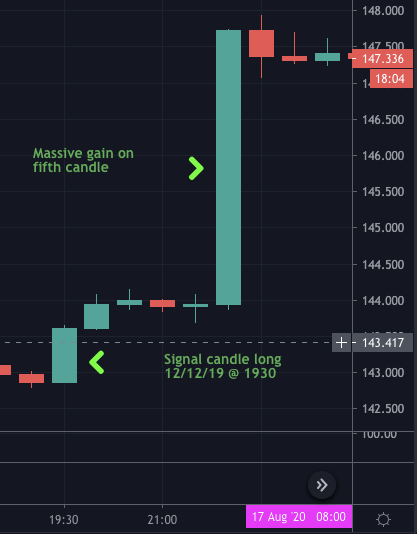

## Admin and restructure

Let's rename some of the features and also re-organise the columns as some are not in a sensible order. 

In [820]:
#Let's start by getting rid of the no trade signal rows
thirtyB = thirtyA[thirtyA.sent_signal != 'no_trade']

In [821]:
#reset the index as we now have great gaps between our original index values
thirtyB.reset_index(inplace=True)

In [822]:
#Now we'll drop out any redundant columns and also rename any features that need this!
thirtyB.drop(columns=['index'], inplace=True)
thirtyB.rename(columns={'%K': 'fast_stoch', 
                     '%D': 'slow_stoch',
                     'RSI': 'rsi',
                     'Plot': '30_sent',
                     '4h_plot': '4h_sent'}, inplace=True)

In [823]:
thirtyB.head(2)

time     open     high      low    close  fast_stoch  \
0  2019-01-07 14:00:00  138.322  138.408  138.268  138.272   91.285107   
1  2019-01-07 15:30:00  138.578  138.687  138.346  138.492   89.649879   

   slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
0   86.681139  60.939545 -0.018425      bullish  0.134107    bullish   
1   90.104441  64.826891  0.002249      bullish  0.134107    bullish   

  candle_dir dt_signal  sent_signal simple_result running_result  profit  \
0      short     short  short_trade           win           loss    0.07   
1      short     short  short_trade           win            win    0.17   

  no_sig_stop  ext_profit running_nosig  tuned_profit  
0         win       0.070          loss         0.070  
1         win       0.227           win         0.154

In [824]:
#Now we need to alter the column order slightly
thirtyB = thirtyB[['time', 'open', 'high', 'low', 'close', 'fast_stoch', 'slow_stoch', 'rsi', '30_sent',
                   'thirty_trend', '4h_sent', 'four_trend', 'candle_dir', 'dt_signal', 'sent_signal',
                   'simple_result', 'running_result', 'profit', 'ext_profit', 'no_sig_stop', 'running_nosig',
                   'tuned_profit']]

In [825]:
thirtyB.head(3)

time     open     high      low    close  fast_stoch  \
0  2019-01-07 14:00:00  138.322  138.408  138.268  138.272   91.285107   
1  2019-01-07 15:30:00  138.578  138.687  138.346  138.492   89.649879   
2  2019-01-07 18:30:00  138.802  138.824  138.532  138.622   86.898499   

   slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
0   86.681139  60.939545 -0.018425      bullish  0.134107    bullish   
1   90.104441  64.826891  0.002249      bullish  0.134107    bullish   
2   91.325175  61.871256  0.022497      bullish  0.167150    bullish   

  candle_dir dt_signal  sent_signal  simple_result running_result  profit  \
0      short     short  short_trade            win           loss   0.070   
1      short     short  short_trade            win            win   0.170   
2      short     short  short_trade  running_short       sig_stop  -0.059   

   ext_profit    no_sig_stop running_nosig  tuned_profit  
0       0.070            win          loss         0.070  
1       0.227            win           win         0.154  
2      -0.059  running_short          loss        -0.222

In [826]:
thirtyB.shape

(2573, 22)

In [830]:
thirtyB.loc[250:256]

time     open     high      low    close  fast_stoch  \
250  2019-03-04 19:30:00  147.130  147.178  147.110  147.164    6.676980   
251  2019-03-04 20:30:00  147.162  147.192  147.140  147.177    7.186298   
252  2019-03-05 10:00:00  147.648  147.668  147.474  147.548   65.531552   
253  2019-03-05 12:00:00  147.540  147.566  147.388  147.432   37.777778   
254  2019-03-05 22:00:00  147.443  147.443  147.348  147.358   93.846460   
255  2019-03-06 06:30:00  146.826  146.940  146.813  146.928   33.908313   
256  2019-03-06 07:30:00  146.792  146.966  146.750  146.904   41.629437   

     slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
250    9.381121  30.446296 -0.067596      bearish -0.036556    bearish   
251    6.201579  31.426362 -0.061650      bearish -0.036556    bearish   
252   66.628093  57.555107  0.037926      bullish -0.110408    bullish   
253   34.757898  51.428553  0.030835      bullish -0.110408    bullish   
254   94.853614  53.597211  0.038862      bullish -0.137266    bullish   
255   27.142099  45.772430 -0.016220      bearish -0.154517    bearish   
256   35.465696  46.008237 -0.013773      bearish -0.154517    bearish   

    candle_dir dt_signal  sent_signal simple_result running_result  profit  \
250       long      long   long_trade      sig_stop      no_runner  -0.002   
251       long      long   long_trade  running_long            win   0.070   
252      short     short  short_trade           win            win   0.170   
253      short     short  short_trade           win            win   0.170   
254      short     short  short_trade           win            win   0.170   
255       long      long   long_trade          loss      no_runner  -0.135   
256       long      long   long_trade           win            win   0.170   

     ext_profit   no_sig_stop running_nosig  tuned_profit  
250      -0.002  running_long           win         0.139  
251       0.070  running_long           win         0.126  
252       0.790           win           win         0.790  
253       0.820           win           win         0.820  
254       0.431           win           win         0.431  
255      -0.135          loss     no_runner        -0.135  
256       0.280           win           win         0.280

In [900]:
#### Note that the second lot of features were not exported ##### 

## Trade Size


In [901]:
## This section remains incomplete

### Rules

The sizes below are arbitrary, it's the escalation that is important. i.e the first trade could be 0.02, 0.5 or 10 lot. Obviously these different lot sizes represent different risk profiles, as this is an experimental strategy we'll start with a very low starting size to limit our risk exposure.

* The first trade has a size of 1 (but it could be anything)
* If the first trade loses then the next trade lot size is doubled 
* An so on if that trade loses the next size is doubled 
* If a trade wins then the next trade returns to a size of 1


In [759]:
max(lstA)

9

In [836]:
thirtyB.loc[665:680]

time     open     high      low    close  fast_stoch  \
665  2019-06-06 11:00:00  137.287  137.632  137.282  137.401   72.742200   
666  2019-06-06 20:00:00  137.730  137.745  137.652  137.676   81.428871   
667  2019-06-07 00:00:00  137.684  137.706  137.590  137.646   60.605715   
668  2019-06-07 02:00:00  137.724  137.724  137.657  137.657   50.000000   
669  2019-06-07 03:00:00  137.709  137.738  137.664  137.686   61.152584   
670  2019-06-07 04:00:00  137.716  137.725  137.674  137.712   72.245467   
671  2019-06-07 05:00:00  137.714  137.747  137.625  137.653   65.494993   
672  2019-06-07 07:30:00  137.884  138.009  137.842  137.857   81.181167   
673  2019-06-07 10:00:00  138.071  138.108  138.010  138.054   84.977181   
674  2019-06-10 05:00:00  138.108  138.110  138.035  138.037   64.544479   
675  2019-06-10 07:00:00  138.124  138.124  138.034  138.052   78.806060   
676  2019-06-10 08:30:00  138.182  138.182  137.794  137.830   55.475366   
677  2019-06-10 13:00:00  137.487  137.574  137.484  137.538    4.773766   
678  2019-06-10 15:30:00  137.608  137.718  137.568  137.701   32.447937   
679  2019-06-10 19:00:00  137.580  137.644  137.575  137.614   34.408602   
680  2019-06-11 06:30:00  137.759  137.813  137.604  137.624   65.771812   

     slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
665   78.188287  54.111014 -0.007782      bearish  0.097013    bearish   
666   77.187886  58.721541  0.021983      bullish  0.105468    bullish   
667   58.469274  55.702448  0.010723      bullish  0.109970    bullish   
668   48.720016  54.851433  0.008439      bullish  0.114657    bullish   
669   57.949456  56.164129  0.008031      bullish  0.114657    bullish   
670   68.408370  57.733052  0.007752      bullish  0.114657    bullish   
671   71.094107  52.093082  0.005070      bullish  0.124731    bullish   
672   83.500937  64.428943  0.011789      bullish  0.124731    bullish   
673   87.013293  72.719958  0.024762      bullish  0.121811    bullish   
674   58.455694  56.537641  0.004365      bullish  0.128339    bullish   
675   71.674099  55.498954  0.003554      bullish  0.128339    bullish   
676   71.383887  41.693683 -0.002045      bullish  0.128339    bullish   
677    5.718331  35.118000 -0.048492      bearish  0.108826    bearish   
678   25.486245  46.489302 -0.034496      bearish  0.108826    bearish   
679   41.696290  42.446916 -0.020002      bearish  0.099221    bearish   
680   70.059657  45.414178  0.010186      bullish  0.095437    bullish   

    candle_dir dt_signal  sent_signal  simple_result running_result  profit  \
665       long      long   long_trade            win            win   0.170   
666      short     short  short_trade            win            win   0.170   
667      short     short  short_trade           loss      no_runner  -0.080   
668      short     short  short_trade           loss      no_runner  -0.087   
669      short     short  short_trade       sig_stop      no_runner  -0.030   
670      short     short  short_trade       sig_stop      no_runner  -0.002   
671      short     short  short_trade       sig_stop      no_runner  -0.025   
672      short     short  short_trade       sig_stop      no_runner  -0.045   
673      short     short  short_trade  running_short            win   0.070   
674      short     short  short_trade  running_short       sig_stop  -0.011   
675      short     short  short_trade       sig_stop      no_runner  -0.038   
676      short     short  short_trade            win            win   0.170   
677       long      long   long_trade            win            win   0.170   
678       long      long   long_trade   running_long       sig_stop   0.039   
679       long      long   long_trade   running_long       sig_stop   0.007   
680      short     short  short_trade       sig_stop      no_runner  -0.118   

     ext_profit    no_sig_stop running_nosig  tuned_profit  
665       0.301            win           win         0.301  
66

In [831]:
thirtyB[thirtyB.tuned_profit<=0]

time     open     high      low    close  fast_stoch  \
2     2019-01-07 18:30:00  138.802  138.824  138.532  138.622   86.898499   
3     2019-01-07 20:30:00  138.829  138.874  138.762  138.816   88.437094   
4     2019-01-07 23:00:00  138.926  138.966  138.878  138.887   90.241474   
10    2019-01-09 03:00:00  138.708  138.774  138.673  138.704   81.652014   
14    2019-01-09 12:00:00  138.702  138.728  138.614  138.696   22.462567   
...                   ...      ...      ...      ...      ...         ...   
2564  2020-08-13 09:00:00  139.692  139.743  139.628  139.662   85.030630   
2565  2020-08-13 11:30:00  140.076  140.164  140.024  140.066   85.201818   
2568  2020-08-14 01:30:00  139.653  139.720  139.618  139.664   43.062606   
2569  2020-08-14 03:30:00  139.596  139.653  139.592  139.617   18.868069   
2570  2020-08-14 05:00:00  139.573  139.618  139.562  139.615   12.974052   

      slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
2      91.325175  61.871256  0.022497      bullish  0.167150    bullish   
3      81.676800  66.758711  0.021740      bullish  0.167150    bullish   
4      91.861208  67.107538  0.019568      bullish  0.183445    bullish   
10     86.384929  61.318828  0.016403      bullish  0.200412    bullish   
14     16.048574  51.003854  0.005486      bullish  0.196126    bullish   
...          ...        ...       ...          ...       ...        ...   
2564   82.990430  68.041436  0.014273      bullish  0.020513    bullish   
2565   90.062279  80.396909  0.044657      bullish  0.020513    bullish   
2568   54.653130  45.154066 -0.023564      bearish  0.014485    bearish   
2569   25.480404  42.865134 -0.028536      bearish  0.014485    bearish   
2570   13.872255  43.995929 -0.028545      bearish  0.007972    bearish   

     candle_dir dt_signal  sent_signal  simple_result running_result  profit  \
2         short     short  short_trade  running_short       sig_stop  -0.059   
3         short     short  short_trade  running_short           loss  -0.078   
4         short     short  short_trade       sig_stop      no_runner  -0.001   
10        short     short  short_trade  running_short       sig_stop   0.000   
14        short     short  short_trade           loss      no_runner  -0.052   
...         ...       ...          ...            ...            ...     ...   
2564      short     short  short_trade           loss      no_runner  -0.101   
2565      short     short  short_trade  running_short           loss  -0.118   
2568       long      long   long_trade       sig_stop      no_runner  -0.030   
2569       long      long   long_trade   running_long           loss  -0.045   
2570       long      long   long_trade   running_long           loss  -0.073   

      ext_profit    no_sig_stop running_nosig  tuned_profit  
2         -0.059  running_short          loss        -0.222  
3         -0.078  running_short          loss        -0.078  
4         -0.001  running_short          loss        -0.099  
10         0.000  running_short          loss        -0.090  
14        -0.052           loss     no_runner        -0.052  
...          ...            ...           ...           ...  
2564      -0.101           loss     no_runner        -0.101  
2565      -0.118  running_short          loss        -0.118  
2568      -0.030   running_long          loss        -0.066  
2569      -0.045   running_long          loss        -0.045  
2570      -0.073   running_long          loss        -0.073  

[1349 rows x 22 columns]

In [838]:
thirtyB.tuned_profit

-0.07800000000000296

In [899]:
date_list = []
date = []
size = []
size_list = []
for i, (j, k) in enumerate(zip(thirtyB.tuned_profit, thirtyB.time)):
    if j <= 0.00:
        size_list.append(j)
    elif j > 0.00 and len(size_list) > 0:
#         print(len(size_list), k, j)
        size.append(len(size_list))
        size_list = []
        
print(max(size))
        
            
# for i in size:
#     if i > 10:
#         print(i)
#     else:
#         continue

21


In [870]:
thirtyB[thirtyB.time == '2019-01-28 06:00:00']

time     open    high      low    close  fast_stoch  \
101  2019-01-28 06:00:00  144.201  144.28  144.192  144.231   16.617456   

     slow_stoch        rsi   30_sent thirty_trend  4h_sent four_trend  \
101   26.464592  44.674705 -0.046322      bearish  0.09207    bearish   

    candle_dir dt_signal sent_signal simple_result running_result  profit  \
101       long      long  long_trade          loss      no_runner  -0.059   

     ext_profit no_sig_stop running_nosig  tuned_profit  
101      -0.059        loss     no_runner        -0.059

In [871]:
thirtyB[80:105]

time     open     high      low    close  fast_stoch  \
80   2019-01-22 14:00:00  141.423  141.434  141.306  141.352   78.377386   
81   2019-01-22 16:00:00  141.782  141.884  141.724  141.735   87.048882   
82   2019-01-22 17:30:00  141.800  141.843  141.728  141.729   77.141788   
83   2019-01-22 19:00:00  141.714  141.736  141.610  141.612   66.518871   
84   2019-01-22 21:00:00  141.716  141.772  141.692  141.713   64.251447   
85   2019-01-22 22:30:00  141.714  141.750  141.644  141.679   56.786800   
86   2019-01-23 00:30:00  141.758  141.804  141.738  141.754   74.634290   
87   2019-01-23 15:00:00  143.409  143.500  143.316  143.360   93.188466   
88   2019-01-23 19:30:00  143.194  143.208  143.131  143.176   47.520228   
89   2019-01-23 21:00:00  143.288  143.291  143.178  143.182   45.763498   
90   2019-01-24 14:00:00  142.824  143.006  142.806  142.856   25.136991   
91   2019-01-24 16:30:00  142.832  143.012  142.822  142.928   32.189156   
92   2019-01-24 18:00:00  142.764  142.903  142.729  142.882   23.643948   
93   2019-01-24 21:30:00  143.118  143.234  143.117  143.234   82.095238   
94   2019-01-25 04:30:00  144.116  144.134  143.946  143.946   87.619739   
95   2019-01-25 05:30:00  144.170  144.230  144.118  144.140   88.852133   
96   2019-01-25 19:00:00  144.783  144.846  144.592  144.601   91.214069   
97   2019-01-25 20:00:00  144.696  144.732  144.659  144.668   82.298424   
98   2019-01-25 21:00:00  144.704  144.748  144.494  144.524   79.591428   
99   2019-01-27 22:30:00  144.733  144.733  144.659  144.684   78.641068   
100  2019-01-28 03:00:00  144.262  144.331  144.204  144.327   15.805499   
101  2019-01-28 06:00:00  144.201  144.280  144.192  144.231   16.617456   
102  2019-01-28 09:30:00  143.858  144.006  143.830  143.950    9.587700   
103  2019-01-28 12:00:00  143.912  144.057  143.892  144.032   35.074403   
104  2019-01-28 13:30:00  143.922  144.110  143.842  144.046   33.443266   

     slow_stoch        rsi   30_sent thirty_trend   4h_sent four_trend  \
80    69.273128  57.248848  0.019911      bullish  0.030417    bullish   
81    89.625994  66.844718  0.049163      bullish  0.030417    bullish   
82    77.137667  63.305487  0.055003      bullish  0.030417    bullish   
83    71.025491  56.540206  0.045317      bullish  0.030797    bullish   
84    63.246865  59.886074  0.034891      bullish  0.030797    bullish   
85    61.198876  57.521270  0.026291      bullish  0.038404    bullish   
86    66.635869  60.736448  0.018095      bullish  0.038404    bullish   
87    95.382710  78.921810  0.083912      bullish  0.095682    bullish   
88    48.335264  65.722125  0.022018      bullish  0.110884    bullish   
89    46.354646  62.445534  0.009125      bullish  0.110884    bullish   
90    21.133739  40.557952 -0.064201      bearish  0.090044    bearish   
91    36.967047  46.466287 -0.052777      bearish  0.090044    bearish   
92    24.265816  46.130111 -0.050521      bearish  0.086946    bearish   
93    81.608098  59.909025 -0.007387      bearish  0.086946    bearish   
94    91.744357  67.004461  0.066081      bullish  0.110409    bullish   
95    88.600082  70.594601  0.066737      bullish  0.110409    bullish   
96    94.993991  66.133318  0.048079      bullish  0.125657    bullish   
97    86.960173  66.929127  0.046433      bullish  0.125657    bullish   
98    82.456745  59.351951  0.037203      bullish  0.125657    bullish   
99    76.907385  62.809025  0.027343      bullish  0.122839    bullish   
100   16.577267  48.778459 -0.036970      bearish  0.111384    bearish   
101   26.464592  44.674705 -0.046322      bearish  0.092070    bearish   
102    8.427744  37.319366 -0.071173      bearish  0.092070    bearish   
103   41.296275  44.609353 -0.054019      bearish  0.076324    bearish   
104   28.627981  46.678052 -0.049963      bearish  0.076324    bearish   

    candle_dir dt_signal  sent_signal  simple_result running_result  profit  \
80       short     short  short_trade  

In [832]:
lst = [3, 6, 8, 5, 6, 2]

In [833]:
lst1 = lst[:: -1]

In [834]:
lst1

[2, 6, 5, 8, 6, 3]